# Test  AI Agent framework  AI A real estate agent 

In [1]:
import os , json, time , gc
import logging


from dotenv import load_dotenv
from IPython.display import display, HTML, Markdown
from tqdm import tqdm
from openai import OpenAI, AsyncOpenAI
from openai.types.chat import (ChatCompletion, 
                               ChatCompletionChunk,
                               ChatCompletionContentPartTextParam, 
                               ChatCompletionContentPartImageParam,
                               ChatCompletionStreamOptionsParam)
import asyncio
import aiohttp
import pandas as pd
import re
import torch
import mlflow

import nest_asyncio
nest_asyncio.apply() # for jupyter notebook

In [2]:
# import crewai AI agent framework # pip install crewai
from crewai import Crew, Agent, Task, Process 

from crewai_tools import ScrapeWebsiteTool, SerperDevTool
from crewai.tools import BaseTool, tool
from crewai import LLM
from pydantic import BaseModel, Field
from typing import List, Dict, Type
from crewai.project import CrewBase, agent, task, crew

import crewai
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any

from crewai.memory import LongTermMemory, ShortTermMemory, EntityMemory
from crewai.memory.storage.rag_storage import RAGStorage
from crewai.memory.storage.ltm_sqlite_storage import LTMSQLiteStorage
from typing import List, Optional
from crewai_tools import ScrapeWebsiteTool, SerperDevTool


/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pydantic/fields.py:1093: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'required'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warn(


In [3]:
# Crawl4AI is a web crawling and data extraction library designed for AI applications.

from crawl4ai import  AsyncWebCrawler, BrowserConfig, CrawlerRunConfig, CacheMode
import crawl4ai


from crawl4ai.chunking_strategy import (RegexChunking, 
                                        NlpSentenceChunking,
                                        OverlappingWindowChunking, 
                                        SlidingWindowChunking,
                                        FixedLengthWordChunking, 
                                        TopicSegmentationChunking) 

from crawl4ai.extraction_strategy import ( JsonCssExtractionStrategy, 
                                           JsonXPathExtractionStrategy,
                                          LLMExtractionStrategy, 
                                          CosineStrategy)
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator


from crawl4ai.content_filter_strategy import BM25ContentFilter, PruningContentFilter, LLMContentFilter

/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/site-packages/pydantic/_internal/_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


In [ ]:
class CFG:

    USE_OPIK = False # for OPIK local LLM framework evaluation

    opikURL = "http://localhost:5173"
    opikProjectName = "AI-real-estate-agent-by-multimodal"

    mlflow_experiment_name = "AI-real-estate-agent-by-multimodal"
    mlflow_tracking_uri = "http://localhost:5000"

     # Set LLM host framework
    USE_OLLAMA = True # for OLLAMA local LLM framework
    USE_OPENROUTER = False # for OpenRouter LLM framework
    USE_OPENAI = False # for OpenAI LLM framework

    # search engine
    num_results = 3 # 5
    queryTime = "month" #"year"

    # Azure Opena Model
    llmModel1 = "gpt-4o-mini"
    llmModel2 = "gpt-4o"
    embedModel1 = "text-embedding-3-small" #1528 openai embedding model
    embedModel2 = "text-embedding-3-large"  # around 3000 dimension
    embedModel3 = "text-embedding-ada-002"
    embedModel4 = "azure-text-embedding-3-small"
    embedModel5 = "azure-text-embedding-3-large"

  
    
    openEmbedModel1 = "intfloat/multilingual-e5-small" # 512 dimension
    openEmbedModel2 = "sentence-transformers/distiluse-base-multilingual-cased-v1"
    openEmbedModel3 = "intfloat/multilingual-e5-large" # curent  # 1024 dimension 
    openEmbedModel4 = "Alibaba-NLP/gte-multilingual-base"
    openEmbedModel5 = "nomic-embed-text" # 768 dimension , support 8196 input 
    openEmbedModel6 = "mixedbread-ai/mxbai-embed-large-v1"  # 
    openEmbedModel7 =   "nomic-embed-text" 

    ollamallmModel1 = "ollama/deepseek-r1:8b"
    ollamallmModel2 = "ollama/deepseek-r1:7b"
    ollamallmModel3 = "ollama/qwen2.5" # Qwen 2.5 7B
    ollamallmModel4 = "ollama/llama3.2"
    ollamallmModel5 = "ollama/qwen3:8b" # Qwen 3 8B


    visionEmbedModel1 = "nomic-ai/nomic-embed-vision-v1.5"
    visionEmbedModel2 =  "openai/clip-vit-base-patch16" # openai vision embeding model 


    promptInjectModel1 = "protectai/deberta-v3-base-prompt-injection-v2"

    htmlMarkdownModel1 = "jinaai/reader-lm-0.5b"
    htmlMarkdownModel2 = "jinaai/reader-lm-1.5b"

    api_base1="http://localhost:11434" # Ollama API base URL

    # Load locally Open source Embedding model 
    modelPath = "./model" 
    fullModelPath = modelPath + "/" + openEmbedModel3

    #General chat completion
    stream = False
    top = 3
    max_tokens = 2048
    top_p = 1
    temperature = 0.5
    presence_penalty = 0
    frequency_penalty = 0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
import sys
import os

# Add parent directory to sys.path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utils import (set_log_level, extractURLs, extractMarkdown)
from web_search_searxg import asyncSearchURL, searchURL

logger = logging.getLogger(__name__)
set_log_level(logger, "DEBUG")


In [7]:
# os.path.abspath(os.path.join(os.getcwd(), '..'))

In [8]:
logger.info(f"Using device: {device}")

2025-09-24 23:40:30,924 - 136517344238464 - 841734249.py-841734249:1 - INFO: Using device: cuda


In [9]:
# set_log_level(logger, "DEBUG")

### Inital Opik for AI agent debug tool

In [ ]:
import opik
from opik.integrations.crewai import track_crewai
from litellm.integrations.opik.opik import OpikLogger
from opik import track

import litellm
from litellm import acompletion


if CFG.USE_OPIK:
    opik.configure(use_local=True, automatic_approvals=True , url=CFG.opikURL)

    opikProjectName = "AI-real-estate-agent-by-multimodal"
    track_crewai(project_name=opikProjectName)
    opik_logger = OpikLogger()
    litellm.callbacks = [opik_logger]

/home/johnsonhk88/.pyenv/versions/3.11.11/lib/python3.11/site-packages/opik/error_tracking/shutdown_hooks.py:12: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  client = sentry_sdk.Hub.current.client


In [11]:
from langchain_ollama import OllamaLLM, ChatOllama
from langchain_openai import ChatOpenAI

In [12]:
import ctypes
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        ctypes.CDLL("libc.so.6").malloc_trim(0)
        gc.collect()
        time.sleep(0.3)

In [13]:
query="Find me a 3 bedroom house in Hong Kong under $5 million"

In [14]:
# from crewai_tools import BraveSearchTool

# # Initialize the tool for internet searching capabilities
# tool = BraveSearchTool()

# SearxNG Web Search Engine

You can [check this link](https://docs.searxng.org/dev/search_api.html) for more informations about `Searx API` parameters.
#### Download SearxNG docker for local host setup web search Engine

In [15]:
# %%time
queryTime = ""  #"month" #"year"#"month" #"year" #"day"
k = 5#5
currentQuery = "What is Hong Kong Weather Now?" #q2 #"Hong Kong Kwun Tong" #q3#tempQuery#q1
categories =  []#[""] #["science"]#["science", "image"]
# query_suffix = searchOptimalConfig #None #searchMapConfig   # searchVideoConfig
urls = await asyncSearchURL(currentQuery, k=k, qureyTime=queryTime, categories=categories)
urls

Time take: 4.046024560928345
Query Categores : []


[{'snippet': '「九天天氣預報」主要是提供未來九天天氣情況的大致趨勢，有關本港當天的詳細天氣預測，請參閱「本港天氣預報」。 「顯著降雨概率」預報為用户提供雨量及未來九天降雨趨勢方面的額外參考。 每日的顯著降雨概率預報表示當日香港廣泛地區累積雨量達到10毫米（即約雨季期間的日降雨量平均值）或以上的機會率。 概率分5個等級： 每100次概率為「高」的預測中，實際上約有70次或以上平均累積雨量達到10毫米或以上。 每100次概率為「中高」的預測中，實際上約有55至69次平均累積雨量達到10毫米或以上。 每100次概率為「中」的預測中，實際上約有45至54次平均累積雨量達到10毫米或以上。 每100次概率為「中低」的預測中，實際上約有30至44次平均累積雨量達到10毫米或以上。',
  'title': '香港九天天氣預報｜香港天文台 (Hko)｜天氣預測',
  'link': 'https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm',
  'engines': ['google', 'duckduckgo'],
  'category': 'general'},
 {'snippet': '每小时本地天气预报、天气情况、降水、露点、湿度、大风 - 尽在 Weather.com 和 The Weather Channel',
  'title': '香港每小时天气预报 - The Weather Channel | Weather.com',
  'link': 'https://weather.com/zh-CN/weather/hourbyhour/l/Hong+Kong?placeId=3d0654fa7f86f5b20cb9cf9de12fd82013d721bacfe9b4a49cd3cc0160b8679e',
  'engines': ['yahoo', 'duckduckgo'],
  'category': 'general'},
 {'snippet': 'Hông là một vùng giải phẫu của động vật có xương sống nằm ở phía ngoài và trước vùng mông, phía dưới mào chậu, và phía trên

In [16]:
df = pd.DataFrame(urls)
df

snippet  \
0  「九天天氣預報」主要是提供未來九天天氣情況的大致趨勢，有關本港當天的詳細天氣預測，請參閱「本...   
1  每小时本地天气预报、天气情况、降水、露点、湿度、大风 - 尽在 Weather.com 和 ...   
2  Hông là một vùng giải phẫu của động vật có xươ...   
3                                     沒有這個頁面的資訊。瞭解原因   
4  香港天文台是一個負責監測及預測天氣、並就與天氣有關的災害發出警告的政府部門。 天文台亦監測和...   

                                           title  \
0                      香港九天天氣預報｜香港天文台 (Hko)｜天氣預測   
1  香港每小时天气预报 - The Weather Channel | Weather.com   
2                    Hông – Wikipedia tiếng Việt   
3                         9-day Weather Forecast   
4                  香港天文台 - Hong Kong Observatory   

                                                link               engines  \
0    https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm  [google, duckduckgo]   
1  https://weather.com/zh-CN/weather/hourbyhour/l...   [yahoo, duckduckgo]   
2            https://vi.wikipedia.org/wiki/H%C3%B4ng                [bing]   
3    http://www.weather.gov.hk/wxinfo/currwx/fnd.htm              [google]   
4               https://www.hko.gov.hk/tc/index.html               [yahoo]   

  category  
0  general  
1  general  
2  general  
3  general  
4  general

In [17]:
urlsList = extractURLs(urls) 
print(urlsList)

['https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm', 'https://weather.com/zh-CN/weather/hourbyhour/l/Hong+Kong?placeId=3d0654fa7f86f5b20cb9cf9de12fd82013d721bacfe9b4a49cd3cc0160b8679e', 'https://vi.wikipedia.org/wiki/H%C3%B4ng', 'http://www.weather.gov.hk/wxinfo/currwx/fnd.htm', 'https://www.hko.gov.hk/tc/index.html']


# Web scaping tool used Crawl4AI tool base on Playwrigth and Chrowmimum browswer


In [18]:
# Bros
# Test  playwright engine
from playwright.async_api import async_playwright

async def playwrightTestWeb():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True) # launch browser
        page = await browser.new_page()
        await page.goto('https://www.google.com')
        print(f"Title of the page: {await page.title()}")
        await page.screenshot(path='example.png')# save screenshot
        await browser.close()

In [19]:
await playwrightTestWeb() # test the browser pylaywright engine

Title of the page: Google


In [20]:

from web_scraping_crawl4ai import getWebPageContentsConcurrent, getWebPageContent

# Single URL Web scraping test

In [21]:
rst = await (getWebPageContent(df.iloc[0].link)) # Get the content of the first URL

[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.25s 

[SCRAPE].. ◆ https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 0.13s 

[COMPLETE] ● https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.38s 

{'url': 'https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm',
 'html': '<!DOCTYPE html><html lang="zh-hk" dir="ltr"><head>\n    <meta charset="UTF-8">\n    <title>香港九天天氣預報｜香港天文台(HKO)｜天氣預測</title>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <meta name="keywords" content=" 香港九天天氣預報">\n    <meta name="description" content="香港天文台提供的未來九天香港天氣預報">\n    <meta name="recordId" content="2018123100000035863">\n    <meta name="lang" content="tc">\n\t<meta property="fb:app_id" content="468280339992518">\n\t<meta property="og:type" content="website">\n\t<meta property="og:title" content="香港天文台提供的未來九天香港天氣預報">\n\t<meta property="og:description" content="香港天文台提供的未來九天香港天氣預報">\n\t<meta property="og:image" content="https://www.hko.gov.hk">\n\t<meta property="og:url" content="https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm">\n\t<meta property="og:image:width" content="600">\n\t<meta property="og:image:height" conten
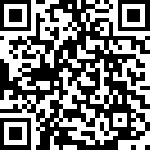

In [22]:
(rst[0].model_dump())

In [23]:
for item in rst:
    print(f"URL: {item.url}")
    # print(f"Title: {item.title}")
    print(f"Content: {item.html[:200]}...")  # Print first 200 characters of content
    # print(f"Images: {item.images}")
    print(f"Links: {item.links}")
    print(f"Markdown: {item.markdown[:200]}...")
    print(f"Metadata: {item.metadata}")  
    # print(f"Text: {item.text[:200]}...")  # Print first 200 characters of text
    print("-" * 80)  # Separator for readability

URL: https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm
Content: <!DOCTYPE html><html lang="zh-hk" dir="ltr"><head>
    <meta charset="UTF-8">
    <title>香港九天天氣預報｜香港天文台(HKO)｜天氣預測</title>
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="view...
Links: {'internal': [{'href': 'https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm', 'text': '跳至主要內容', 'title': '跳至主要內容', 'base_domain': 'hko.gov.hk', 'head_data': None, 'head_extraction_status': None, 'head_extraction_error': None, 'intrinsic_score': 0.0, 'contextual_score': None, 'total_score': None}, {'href': 'https://www.hko.gov.hk/tc/index.html', 'text': '', 'title': '', 'base_domain': 'hko.gov.hk', 'head_data': None, 'head_extraction_status': None, 'head_extraction_error': None, 'intrinsic_score': 0.0, 'contextual_score': None, 'total_score': None}, {'href': 'https://www.hko.gov.hk/tc/gts/time/conversion.htm', 'text': '', 'title': '公曆農曆對照', 'base_domain': 'hko.gov.hk', 'head_data': None, 'head_extraction_status': None, 'he

In [24]:
# urls = extractURLs(rst)

In [25]:
markdowns = extractMarkdown(rst, types="all", extract="raw_markdown")

Markdown: [跳至主要內容](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mainContentSkip "跳至主要內容")
[![香港天文台](https://www.hko.gov.hk/images/logo_hko_inside_c.png)](https://www.hko.gov.hk/tc/index.html)
個人版網站![個人版網站](h...


In [26]:
Markdown(markdowns[0])

[跳至主要內容](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mainContentSkip "跳至主要內容")
[![香港天文台](https://www.hko.gov.hk/images/logo_hko_inside_c.png)](https://www.hko.gov.hk/tc/index.html)
個人版網站![個人版網站](https://www.hko.gov.hk/images/PersonalizedIcon.png)分享![分享](https://www.hko.gov.hk/images/icon_share.png)搜尋![搜尋](https://www.hko.gov.hk/images/icon_search.png)語言![語言](https://www.hko.gov.hk/images/icon_language.png)選單![選單](https://www.hko.gov.hk/images/btn_mobileMenu.png)
2025年9月24日 (三)
[![公曆農曆對照](https://www.hko.gov.hk/images/icon_date.png)](https://www.hko.gov.hk/tc/gts/time/conversion.htm "公曆農曆對照")
| 
![三號戒備信號](https://www.hko.gov.hk/images/HKOWarningSymbols_m/warn800_02_tc3.png)
![山泥傾瀉警告](https://www.hko.gov.hk/images/HKOWarningSymbols_m/warn800_14_ls.png)
| 
![雨](https://www.hko.gov.hk/images/HKOWxIconOutline/Outline_wxicon_pic63.png)
27.1°C
90%
(23:30)
  * [ENGEng](javascript:chglang\(0\))
  * [简简](javascript:chglang\(2\))


[文字大小](https://www.hko.gov.hk/tc/other/textsize.html)
[![書籤](https://www.hko.gov.hk/images/icon_bookmark_setting.png)書籤](https://www.hko.gov.hk/tc/bookmark.html)
[![分享](https://www.hko.gov.hk/images/icon_share.png)](javascript:trigger_shareTool\(\))
[這連結會以新視窗打開。![Facebook](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[這連結會以新視窗打開。![X](https://www.hko.gov.hk/images/follow/x_black_100px.png)](https://x.com/intent/tweet?url=https%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[這連結會以新視窗打開。![微博](https://www.hko.gov.hk/images/follow/sina.png)](http://service.weibo.com/share/share.php?url=http%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[![電郵](https://www.hko.gov.hk/images/follow/email.png)](javascript:email\(\))[![二維碼](https://www.hko.gov.hk/images/icon_qrcode.png)](javascript:showQrcode\(\))
  

[![搜索](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
[![搜索](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
  * [天氣展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)本港天氣相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=8)
      * [分區天氣](https://www.hko.gov.hk/tc/wxinfo/ts/index.htm)
      * [天氣照片](https://www.hko.gov.hk/tc/wxinfo/ts/index_webcam.htm)
      * [雨量分佈圖](https://www.hko.gov.hk/tc/wxinfo/rainfall/item_list.htm)
      * [紫外線資訊](https://www.hko.gov.hk/tc/wxinfo/uvinfo/uvinfo.html)
      * [香港水域能見度](https://www.hko.gov.hk/tc/vis/vis_index.shtml)
      * [天氣報告](https://www.hko.gov.hk/tc/wxinfo/currwx/current.htm)
      * [昨日天氣及輻射水平資料](https://www.hko.gov.hk/tc/wxinfo/pastwx/ryes.htm)
      * [過去天氣](https://www.hko.gov.hk/tc/wxinfo/pastwx/past.htm)
      * [香港高空氣象觀測](https://www.hko.gov.hk/tc/out_photo/upper-air-weather.htm)
      * [京士柏氣象站](https://www.hko.gov.hk/tc/wxinfo/aws/kpinfo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)天氣預測相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=15)
      * [本港地區天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/flw.htm)
      * [九天天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [特別天氣提示](https://www.hko.gov.hk/tc/sweather_tips.html)
      * [延伸預報](https://www.hko.gov.hk/tc/probfcst/tempfcst.htm)
      * [這連結會以新視窗打開。自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)
      * [這連結會以新視窗打開。兩小時降雨預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncrf)
      * [這連結會以新視窗打開。一小時閃電預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncln)
      * [紫外線指數預測](https://www.hko.gov.hk/tc/wxinfo/uvinfo/uvinfo.html)
      * [華南海域天氣報告](https://www.hko.gov.hk/tc/wxinfo/currwx/ffish.htm)
      * [船舶天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fmar.htm)
      * [電腦預測天氣圖](https://www.hko.gov.hk/tc/nhm/nhme.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/today_weather.png)天氣警告相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=25)
      * [今日天氣警告](https://www.hko.gov.hk/tc/wxinfo/dailywx/wxwarntoday.htm)
      * [詳細警告資料](https://www.hko.gov.hk/tc/detail.htm)
      * [大雨及雷暴區域資訊](https://www.hko.gov.hk/tc/rhr/main.html)
      * [熱帶氣旋警告（本港地區）](https://www.hko.gov.hk/tc/wxinfo/currwx/tc.htm)
      * [各類警告詳細資料](https://www.hko.gov.hk/tc/wservice/warning/details.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/fishermen.png)漁民天氣](https://www.hko.gov.hk/tc/fishermen/main.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/marine.png)航運天氣相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=1370)
      * [航運界天氣資料](https://www.hko.gov.hk/tc/wservice/tsheet/pms/mariners.htm)
      * [香港海港氣象服務](https://www.hko.gov.hk/tc/wservice/tsheet/pms/index.htm)
      * [這連結會以新視窗打開。我的海洋天氣圖像廊](https://maps.weather.gov.hk/sea/index_uc.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)航空天氣](https://www.hko.gov.hk/tc/aviat/amt/amsmain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wx-1.png)天氣監測圖像相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=1323)
      * [雷達圖像](https://www.hko.gov.hk/tc/wxinfo/radars/radar_range1.htm)
      * [閃電位置資訊服務](https://www.hko.gov.hk/tc/wxinfo/llis/gm_index.htm)
      * [氣象衛星圖片](https://www.hko.gov.hk/tc/wxinfo/intersat/satellite/sate.htm)
      * [天氣圖](https://www.hko.gov.hk/tc/wxinfo/currwx/wxcht.htm)
      * [沙塵天氣資訊](https://www.hko.gov.hk/tc/wxinfo/sanddust/sdawx.html)
      * [反軌跡路線圖](https://www.hko.gov.hk/tc/wxinfo/trajectory/trajectory.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/gis.png)地理信息系統天氣服務相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=26)
      * [這連結會以新視窗打開。地球天氣](https://maps.weather.gov.hk/wxviewer/index.html?lang=tc)
      * [這連結會以新視窗打開。地圖天氣](https://maps.weather.gov.hk/gis-portal/web/index_uc.html)
      * [這連結會以新視窗打開。分區天氣](https://maps.weather.gov.hk/index_uc.html)
      * [這連結會以新視窗打開。指定地點閃電戒備服務](https://maps.weather.gov.hk/llis/llaw_uc.html)
      * [這連結會以新視窗打開。自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)
      * [這連結會以新視窗打開。兩小時降雨預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncrf)
      * [這連結會以新視窗打開。一小時閃電預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncln)
    * [![](https://www.hko.gov.hk/images/dropdown/typhoon.png)熱帶氣旋](https://www.hko.gov.hk/tc/informtc/tcMain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/china.png)中國天氣相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=33)
      * [中國城市天氣](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm?ra=2&place=1)
      * [這連結會以新視窗打開。粵港澳大灣區天氣網站](https://www.gbaweather.net/tc/)
      * [廣東省主要城市天氣](https://www.hko.gov.hk/tc/wxinfo/climat/gdwx.htm)
      * [廣東省及鄰近地區雨量資料](https://www.hko.gov.hk/tc/wxinfo/gdrf/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)世界天氣相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=37)
      * [世界天氣資訊](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm)
      * [機場天氣報告](https://www.hko.gov.hk/tc/aviat/airportwx/w_airport_wx.htm)
      * [亞洲地區地面氣候平均氣溫](https://www.hko.gov.hk/tc/wxinfo/climat/temp.htm)
      * [亞洲地區地面氣候平均風速](https://www.hko.gov.hk/tc/wxinfo/climat/wind.htm)
  * [氣候展開](https://www.hko.gov.hk/tc/sitemap.html?menu=2)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)香港的氣候](https://www.hko.gov.hk/tc/cis/climahk.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_information_service.png)氣候資料服務](https://www.hko.gov.hk/tc/cis/climat.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/warning.png)警告及信號資料庫](https://www.hko.gov.hk/tc/cis/warndb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wwx_statistic.png)特殊天氣現象統計資料](https://www.hko.gov.hk/tc/cis/statistic.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/monthly.png)每月天氣摘要](https://www.hko.gov.hk/tc/wxinfo/pastwx/mws/mws.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)氣候預報相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=2&submenu=43)
      * [月預報](https://www.hko.gov.hk/tc/wxinfo/month/month.htm)
      * [季度預報](https://www.hko.gov.hk/tc/wxinfo/season/season.htm)
      * [全年展望](https://www.hko.gov.hk/tc/wxinfo/season/anlf.htm)
      * [背景資料](https://www.hko.gov.hk/tc/wxinfo/season/bkgd.htm)
      * [預報方法](https://www.hko.gov.hk/tc/wxinfo/season/met.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_change.png)氣候變化相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=2&submenu=46)
      * [氣候變化](https://www.hko.gov.hk/tc/climate_change/climate_change.htm)
      * [氣候變化的影響](https://www.hko.gov.hk/tc/climate_change/climate_change_impacts.htm)
      * [全球氣候變化](https://www.hko.gov.hk/tc/climate_change/global_climchge.htm)
      * [香港氣候變化](https://www.hko.gov.hk/tc/climate_change/climate_change_hk.htm)
      * [氣候變化的原因](https://www.hko.gov.hk/tc/climate_change/human_activities.htm)
      * [全球氣候推算](https://www.hko.gov.hk/tc/climate_change/proj_global.htm)
      * [香港氣候推算](https://www.hko.gov.hk/tc/climate_change/future_climate.htm)
      * [氣候變化小百科](https://www.hko.gov.hk/tc/climate_change/faq/faq.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/el_nino_and_la_nina.png)厄爾尼諾與拉尼娜](https://www.hko.gov.hk/tc/lrf/enso/enso-front.htm)
  * [地球物理展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1277)
    * [![](https://www.hko.gov.hk/images/dropdown/earthquake.png)地震相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1277&submenu=1278)
      * [這連結會以新視窗打開。地震速報 (M6.0+ 及 有感) - Twitter頻道](https://twitter.com/HKOEARTHQUAKE6C)
      * [這連結會以新視窗打開。地震速報 (M5.0+) - Twitter頻道](https://twitter.com/HKOEARTHQUAKE5C)
      * [全球地震資訊網](https://www.hko.gov.hk/tc/gts/equake/quake-info.htm)
      * [地震報告](https://www.hko.gov.hk/tc/gts/equake/neqpress.htm)
      * [報告香港有感地震](https://www.hko.gov.hk/tc/gts/s/q.htm)
      * [地震監測](https://www.hko.gov.hk/tc/gts/equake/seismic_mon.htm)
      * [認識地震](https://www.hko.gov.hk/tc/gts/equake/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tsunami.png)海嘯相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1277&submenu=1279)
      * [海嘯報告及警告](https://www.hko.gov.hk/tc/gts/equake/tsunami_info_warn.htm)
      * [認識海嘯](https://www.hko.gov.hk/tc/gts/equake/und_tsu.htm)
      * [香港的海嘯監測及警告](https://www.hko.gov.hk/tc/gts/equake/tsunami_mon.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-3.png)潮汐相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1277&submenu=1280)
      * [潮汐資料](https://www.hko.gov.hk/tc/tide/marine/realtide.htm)
      * [潮汐預報](https://www.hko.gov.hk/tc/tide/predtide.htm)
      * [潮汐站照片](https://www.hko.gov.hk/tc/tide/tide_station_photos.html)
      * [2025年香港潮汐表](https://www.hko.gov.hk/tc/tide/tidetable2025.html)
      * [2024年香港潮汐表](https://www.hko.gov.hk/tc/tide/tidetable2024.html)
      * [個別潮汐站數據](https://www.hko.gov.hk/tc/cis/hydrological/tideData.htm)
      * [風暴潮記錄](https://www.hko.gov.hk/tc/wservice/tsheet/pms/stormsurgedb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geomagnetic.png)地磁](https://www.hko.gov.hk/tc/gts/equake/qe_geomagnetism.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-5.png)太空天氣](https://www.hko.gov.hk/tc/education/spacewx/index.htm)
  * [天文及授時展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1292)
    * [![](https://www.hko.gov.hk/images/dropdown/astronomy_information.png)天文觀測天氣資訊](https://www.hko.gov.hk/tc/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-1.png)互動版太陽路徑圖](https://www.hko.gov.hk/tc/gts/astronomy/SunPathDay3_ue.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-2.png)天文資料相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1292&submenu=1295)
      * [二十四節氣的日期及時間資料](https://www.hko.gov.hk/tc/gts/astronomy/Solar_Term.htm)
      * [日上中天的時間、方位及仰角](https://www.hko.gov.hk/tc/gts/astronomy/Sun_Transit.htm)
      * [太陽視赤經與視赤緯](https://www.hko.gov.hk/tc/gts/astronomy/sun_ra_dec.htm)
      * [月相的日期及時間資料](https://www.hko.gov.hk/tc/gts/astronomy/Moon_Phase.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-3.png)有趣天文現象相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1292&submenu=1296)
      * [網上天文相簿](https://www.hko.gov.hk/tc/gts/event/astro-photo.htm)
      * [日食](https://www.hko.gov.hk/tc/gts/event/event-solar-eclps1.htm)
      * [月食](https://www.hko.gov.hk/tc/gts/event/event-lunar-eclps1.htm)
      * [彗星](https://www.hko.gov.hk/tc/gts/event/event-comet.htm)
      * [流星和流星雨](https://www.hko.gov.hk/tc/gts/event/event-meteor.htm)
      * [木星衝](https://www.hko.gov.hk/tc/gts/event/event-jupiter.htm)
      * [土星衝](https://www.hko.gov.hk/tc/gts/event/event-saturn.htm)
      * [五星匯聚](https://www.hko.gov.hk/tc/gts/event/event-parade.htm)
      * [金星凌日](https://www.hko.gov.hk/tc/gts/event/event-venus-transit.htm)
      * [行星視運動](https://www.hko.gov.hk/tc/gts/event/event-apparent-motion.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-4.png)授時服務相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1292&submenu=1297)
      * [網上時鐘](https://www.hko.gov.hk/tc/gts/time/clock_e.html)
      * [網絡時間服務](https://www.hko.gov.hk/tc/nts/ntime.htm)
      * [世界時區圖](https://www.hko.gov.hk/tc/gts/time/worldtime2.htm)
      * [香港標準時間](https://www.hko.gov.hk/tc/gts/time/hk_standard_time.htm)
      * [香港夏令時間](https://www.hko.gov.hk/tc/gts/time/Summertime.htm)
      * [香港授時服務歷史](https://www.hko.gov.hk/tc/gts/time/History_of_HK_Time_Service.htm)
      * [香港時間系統](https://www.hko.gov.hk/tc/gts/time/hk_time_services.htm)
      * [時間校對服務](https://www.hko.gov.hk/tc/gts/time/Clocksyn.htm)
      * [授時的基本術語](https://www.hko.gov.hk/tc/gts/time/item_list.htm)
      * [香港授時系統演變歷程](https://www.hko.gov.hk/tc/gts/time/Milestones.htm)
      * [香港子午線](https://www.hko.gov.hk/tc/gts/time/hk-meridian.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-5.png)曆法相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1292&submenu=1312)
      * [農曆曆法](https://www.hko.gov.hk/tc/gts/time/lunarcal.htm)
      * [二十四節氣](https://www.hko.gov.hk/tc/gts/time/24solarterms.htm)
      * [天干和地支](https://www.hko.gov.hk/tc/gts/time/stemsandbranches.htm)
      * [十二生肖](https://www.hko.gov.hk/tc/gts/time/12animals.htm)
      * [公曆與農曆對照表](https://www.hko.gov.hk/tc/gts/time/conversion.htm)
      * [21世紀與第3個千年何時開始](https://www.hko.gov.hk/tc/gts/time/centy-21-e.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-6.png)年曆相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1292&submenu=1308)
      * [2025年年曆](https://www.hko.gov.hk/tc/gts/astron2025/almanac2025_index.htm)
      * [2026年年曆](https://www.hko.gov.hk/tc/gts/astron2026/almanac2026_index.htm)
      * [2027年年曆](https://www.hko.gov.hk/tc/gts/astron2027/almanac2027_index.htm)
  * [輻射監測展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1313)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-1.png)實時香港輻射水平](https://www.hko.gov.hk/tc/radiation/monitoring/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-2.png)認識輻射](https://www.hko.gov.hk/tc/radiation/monitoring/landing_understanding_radiation.html)
    * [![](https://www.hko.gov.hk/images/dropdown/radiation_website.png)輻射監測、評價及防護](https://www.hko.gov.hk/tc/radiation/monitoring/landingEnvironmentMonitoring.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-5.png)環境輻射監測計劃](https://www.hko.gov.hk/tc/radiation/monitoring/landing_ermp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-8.png)大亞灣應變計劃](https://www.hko.gov.hk/tc/radiation/monitoring/landing_dbcp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)相關網站相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1313&submenu=1486)
      * [這連結會以新視窗打開。保安局－香港特別行政區大亞灣應變計劃](https://www.sb.gov.hk/chi/special/nuclear/DBCP.html)
      * [這連結會以新視窗打開。環境及生態局－對日本食品的進口管制](https://www.eeb.gov.hk/food/cn/our_work/fs2.html)
      * [這連結會以新視窗打開。食物安全中心－對日本進口食品進行輻射水平的檢測概況](https://www.cfs.gov.hk/tc_chi/programme/programme_rafs/daily_japan_nuclear_incidents.html)
      * [這連結會以新視窗打開。衞生署－放射衞生常見問題及詞彙](https://www.dh.gov.hk/faq_tc.html)
      * [這連結會以新視窗打開。漁農自然護理署－漁產品的輻射水平測試](https://www.afcd.gov.hk/tc_chi/fisheries/Radiological_testing/Radiological_Test.html)
  * [社群展開](https://www.hko.gov.hk/tc/sitemap.html?menu=3)
    * [![](https://www.hko.gov.hk/images/dropdown/school.png)學校](https://www.hko.gov.hk/tc/school/school.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tour.png)旅遊相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=3&submenu=63)
      * [這連結會以新視窗打開。香港旅遊天氣資訊](https://visithk.weather.gov.hk/index_uc.htm)
      * [世界天氣資訊](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/sport.png)運動相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=3&submenu=57)
      * [飛行運動天氣資訊](https://www.hko.gov.hk/tc/aviat/soaring/index.shtml)
      * [水上運動天氣資訊](https://www.hko.gov.hk/tc/sports/watersports.shtml)
      * [這連結會以新視窗打開。香港遠足路徑天氣服務](https://www.hko.gov.hk/tc/103461/%E9%A6%99%E6%B8%AF%E9%81%A0%E8%B6%B3%E8%B7%AF%E5%BE%91%E5%A4%A9%E6%B0%A3%E6%9C%8D%E5%8B%99)
    * [![](https://www.hko.gov.hk/images/dropdown/photo_shooting.png)戶外攝影](https://www.hko.gov.hk/tc/out_photo/outdoor_photo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/district.png)社區天氣觀測計劃相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=3&submenu=1367)
      * [這連結會以新視窗打開。社區天氣觀測計劃 Facebook 群組](https://www.facebook.com/groups/icwos/)
      * [社區天氣觀測計劃圖像廊](https://www.hko.gov.hk/tc/community/cwos/cwos-album.html)
    * [![](https://www.hko.gov.hk/images/dropdown/elderly.png)長者](https://www.hko.gov.hk/tc/sports/socare/socare.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/stargazers.png)觀星](https://www.hko.gov.hk/tc/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/friend.png)天文台之友](https://www.hko.gov.hk/tc/education/friends_hko/edu03_friends.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/district.png)社區天氣資訊網絡](https://cowin.hku.hk/chinese/map.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/little_hko.png)小小天文台](https://kids.weather.gov.hk/tc/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/interactivemap_icon.png)山竹風暴破壞互動地圖](https://www.hko.gov.hk/tc/cwsrc/index_mangkhut.html)
  * [學習展開](https://www.hko.gov.hk/tc/sitemap.html?menu=4)
    * [![](https://www.hko.gov.hk/images/dropdown/education.png)教育資源](https://www.hko.gov.hk/tc/education/edu.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/360-tour-logo-small.png)360 漫遊天文台](https://www.hko.gov.hk/tc/virtual-tour/360-Virtual-Tour.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/little_hko.png)小小天文台](https://kids.weather.gov.hk/V2/wx4k_index_c.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/radiation-ebook-icon.png)輻射解碼](https://kids.weather.gov.hk/eBook/ebook_radiation/index_uc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/TC-Ebook-icon40x30.png)熱帶氣旋之旅](https://kids.weather.gov.hk/eBook/ebook_TC/tablet_zh.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/cloud.png)「度天」賞雲](https://kids.weather.gov.hk/V2/eBook/ebook_cloud/ebook_shelf_uc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/world_cloud.png)國際雲圖（簡體中文）](https://cloudatlas.wmo.int/zh-hans/home.html)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_all.png)天文台全方位遊](https://www.hko.gov.hk/tc/education/art/hko_tour.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/std-1.png)公眾課程及活動](https://www.hko.gov.hk/tc/education/edu03course.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/e-Bulletins.png)訂閱電子通訊](https://www.hko.gov.hk/tc/education/ebulletin/ebulletin.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/research.png)研究論壇](https://www.hko.gov.hk/tc/research_forum/research_forum.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/publication.png)刊物](https://www.hko.gov.hk/tc/publica/publica.htm%20)
  * [國際及區域合作展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1348)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)世界氣象組織相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1348&submenu=1375)
      * [這連結會以新視窗打開。世界天氣信息服務](https://worldweather.wmo.int/tc/home.html)
      * [這連結會以新視窗打開。惡劣天氣信息中心（英文）](https://severeweather.wmo.int/)
      * [這連結會以新視窗打開。國際雲圖 （簡體中文）](https://cloudatlas.wmo.int/zh-hans/home.html)
      * [這連結會以新視窗打開。全球多災種預警系統 – 亞洲（英文）](https://gmas.asia/%20)
      * [這連結會以新視窗打開。觀測、基礎設施與信息系統委員會（英文）](https://community.wmo.int/en/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom)
      * [這連結會以新視窗打開。天氣、氣候、水文、海洋及相關環境服務與應用委員會（英文）](https://wmo.int/about-wmo/governance/technical-commissions/services-commission-sercom%20)
      * [這連結會以新視窗打開。世界氣象日](https://wmo.int/zh-hans/shijieqixiangri)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)國際民航組織相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=1348&submenu=1394)
      * [這連結會以新視窗打開。氣象學專家組（英文）](https://www.icao.int/airnavigation/metp/pages/default.aspx)
      * [這連結會以新視窗打開。亞太地區航空策劃和實施工作小組（英文）](https://www.icao.int/APAC/Pages/apanpirg.aspx)
      * [這連結會以新視窗打開。亞太辦公室（英文）](https://www.icao.int/APAC/Pages/default.aspx)
      * [這連結會以新視窗打開。亞太地區分辦事處（英文）](https://www.icao.int/APAC/APAC-RSO/Pages/default.aspx)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-10.png)國際原子能機構](https://www.hko.gov.hk/tc/iaea.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/smc_nowcasting.png)臨近預報區域專業氣象中心（英文）](https://rsmc.hko.gov.hk/nowcast/)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/tsunami.png)南海海嘯預警中心（英文）](http://scstac.oceanguide.org.cn/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aamc.png)亞洲航空氣象中心](https://www.hko.gov.hk/tc/intco/aamc.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)合作伙伴](https://www.hko.gov.hk/tc/intco/partners.html)
  * [媒體及消息展開](https://www.hko.gov.hk/tc/sitemap.html?menu=5)
    * [![](https://www.hko.gov.hk/images/dropdown/new-2.png)社交媒體相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=5&submenu=1354)
      * [這連結會以新視窗打開。Facebook](https://www.facebook.com/hk.observatory/)
      * [這連結會以新視窗打開。YouTube](https://www.youtube.com/user/hkweather)
      * [這連結會以新視窗打開。X](https://x.com/hkobservatory)
      * [這連結會以新視窗打開。新浪微博](https://www.weibo.com/hkobservatory?is_ori=1)
      * [微信](https://www.hko.gov.hk/tc/WeChat/wx_info_wechat.htm)
      * [這連結會以新視窗打開。Instagram](https://www.instagram.com/hk.observatory/)
      * [這連結會以新視窗打開。土豆](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
      * [這連結會以新視窗打開。地震速報 (M6.0+及有感) - X頻道](https://x.com/HKOEARTHQUAKE6C)
      * [這連結會以新視窗打開。地震速報 (M5.0+) - X頻道](https://x.com/HKOEARTHQUAKE5C)
    * [![](https://www.hko.gov.hk/images/dropdown/press.png)新聞公報](https://www.hko.gov.hk/tc/press/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/news.png)最新消息](https://www.hko.gov.hk/tc/whatsnew/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)天文台最新動態](https://www.hko.gov.hk/tc/hkonews/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/qna.png)立法會答問](https://www.hko.gov.hk/tc/abouthko/legco/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/200508%20TTSD%20Icon-04.png)談天說地](https://www.hko.gov.hk/tc/education/friends_hko/e-newsletter/focus.html)
    * [![](https://www.hko.gov.hk/images/dropdown/blog.png)天文台網誌](https://www.hko.gov.hk/tc/blog/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/pen.png)天氣隨筆](https://www.hko.gov.hk/tc/forecaster_blog/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/on_air.png)天氣廣播站](https://www.hko.gov.hk/tc/video/weatheronair.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/stuff.png)氣象冷知識](https://www.youtube.com/playlist?list=PLBdhEGSPvUGVuK7fZUxHKzv51Y_2hy_hW)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/news_info.png)新聞發佈會](https://www.youtube.com/playlist?list=PLBdhEGSPvUGUUTScwNU-egaRtvNbx9dsk)
    * [![](https://www.hko.gov.hk/images/dropdown/new-3.png)有關熱帶氣旋的廣播](https://www.hko.gov.hk/tc/wxinfo/currwx/tc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/youtube.png)天文台消息](https://www.youtube.com/playlist?list=PLBdhEGSPvUGX1EWW54Zt7XN8kFf5NQ-wb)
    * [![](https://www.hko.gov.hk/images/dropdown/careers.png)職位空缺](https://www.hko.gov.hk/tc/vacancy/vacancy.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/new-1.png)招標公布](https://www.hko.gov.hk/tc/tender/tender_index.htm)
  * [電子服務展開](https://www.hko.gov.hk/tc/sitemap.html?menu=6)
    * [![](https://www.hko.gov.hk/images/dropdown/apps.png)應用程式相關項目展開](https://www.hko.gov.hk/tc/sitemap.html?menu=6&submenu=87)
      * [我的天文台](https://www.hko.gov.hk/tc/myobservatory.htm)
      * [這連結會以新視窗打開。我的世界天氣](https://worldweather.wmo.int/tc/apps.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/ele-1.png)個人版網站](https://my.weather.gov.hk/personalized-website/traditional_chinese)
    * [![](https://www.hko.gov.hk/images/dropdown/wizard.png)天氣精靈](https://www.hko.gov.hk/tc/wxinfo/wxwizard/wxwizard.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/text.png)文字版本](https://www.hko.gov.hk/textonly/v2/indexc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/rss.png)RSS天氣資訊頻道](https://rss.weather.gov.hk/rss_uc.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ele-3.png)有聲網頁](https://www.hko.gov.hk/tc/audio/index.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/form.png)表格](https://www.hko.gov.hk/tc/e_services.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/data.png)開放數據集](https://www.hko.gov.hk/tc/abouthko/opendata_intro.htm)
  * [關於我們展開](https://www.hko.gov.hk/tc/sitemap.html?menu=7)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)關於香港天文台](https://www.hko.gov.hk/tc/abouthko/aboutus.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/film.png)天文台部門短片](https://www.youtube.com/watch?v=PEc2PDngmxU)
    * [![](https://www.hko.gov.hk/images/dropdown/mission.png)抱負和使命](https://www.hko.gov.hk/tc/abouthko/hkovmv.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)服務承諾](https://www.hko.gov.hk/tc/abouthko/pledge.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/chart.png)組織結構](https://www.hko.gov.hk/tc/abouthko/chart/orgcht.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/quality.png)品質管理](https://www.hko.gov.hk/tc/abouthko/quality.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/facts.png)香港天文台 - 香港便覽](https://www.hko.gov.hk/tc/abouthko/hko.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_work.png)香港天文台2024](https://www.hko.gov.hk/tc/abouthko/files/hko2024c_Final.pdf)
    * [![](https://www.hko.gov.hk/images/dropdown/services.png)服務概覽](https://www.hko.gov.hk/tc/wservice/wservice.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/prog_areas.png)天文台綱領範圍](https://www.hko.gov.hk/tc/abouthko/program.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/history.png)香港天文台的歷史](https://www.hko.gov.hk/tc/abouthko/history.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/career.png)事業＠香港天文台](https://www.hko.gov.hk/tc/career/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/visitors.png)瀏覽數字](https://www.hko.gov.hk/tc/abouthko/visits/visitor.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/OpenDayIcon.png)香港天文台開放日2025](https://www.hkoopenday.gov.hk/)


選單![](https://www.hko.gov.hk/images/btn_Menu.png)
瀏覽記錄
[![主頁](https://www.hko.gov.hk/images/icon_home_left_menu.png)主頁](https://www.hko.gov.hk/tc/)
搜索![搜索](https://www.hko.gov.hk/images/icon_search.png)
[![擴展](https://www.hko.gov.hk/images/down_arrow.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
[![折疊](https://www.hko.gov.hk/images/up_arrow.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
  * [天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)本港天氣相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [分區天氣](https://www.hko.gov.hk/tc/wxinfo/ts/index.htm)
      * [天氣照片](https://www.hko.gov.hk/tc/wxinfo/ts/index_webcam.htm)
      * [雨量分佈圖](https://www.hko.gov.hk/tc/wxinfo/rainfall/item_list.htm)
      * [紫外線資訊](https://www.hko.gov.hk/tc/wxinfo/uvinfo/uvinfo.html)
      * [香港水域能見度](https://www.hko.gov.hk/tc/vis/vis_index.shtml)
      * [天氣報告](https://www.hko.gov.hk/tc/wxinfo/currwx/current.htm)
      * [昨日天氣及輻射水平資料](https://www.hko.gov.hk/tc/wxinfo/pastwx/ryes.htm)
      * [過去天氣](https://www.hko.gov.hk/tc/wxinfo/pastwx/past.htm)
      * [香港高空氣象觀測](https://www.hko.gov.hk/tc/out_photo/upper-air-weather.htm)
      * [京士柏氣象站](https://www.hko.gov.hk/tc/wxinfo/aws/kpinfo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)天氣預測相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [本港地區天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/flw.htm)
      * [九天天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [特別天氣提示](https://www.hko.gov.hk/tc/sweather_tips.html)
      * [延伸預報](https://www.hko.gov.hk/tc/probfcst/tempfcst.htm)
      * [這連結會以新視窗打開。自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)
      * [這連結會以新視窗打開。兩小時降雨預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncrf)
      * [這連結會以新視窗打開。一小時閃電預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncln)
      * [紫外線指數預測](https://www.hko.gov.hk/tc/wxinfo/uvinfo/uvinfo.html)
      * [華南海域天氣報告](https://www.hko.gov.hk/tc/wxinfo/currwx/ffish.htm)
      * [船舶天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fmar.htm)
      * [電腦預測天氣圖](https://www.hko.gov.hk/tc/nhm/nhme.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/today_weather.png)天氣警告相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [今日天氣警告](https://www.hko.gov.hk/tc/wxinfo/dailywx/wxwarntoday.htm)
      * [詳細警告資料](https://www.hko.gov.hk/tc/detail.htm)
      * [大雨及雷暴區域資訊](https://www.hko.gov.hk/tc/rhr/main.html)
      * [熱帶氣旋警告（本港地區）](https://www.hko.gov.hk/tc/wxinfo/currwx/tc.htm)
      * [各類警告詳細資料](https://www.hko.gov.hk/tc/wservice/warning/details.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/fishermen.png)漁民天氣](https://www.hko.gov.hk/tc/fishermen/main.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/marine.png)航運天氣相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [航運界天氣資料](https://www.hko.gov.hk/tc/wservice/tsheet/pms/mariners.htm)
      * [香港海港氣象服務](https://www.hko.gov.hk/tc/wservice/tsheet/pms/index.htm)
      * [這連結會以新視窗打開。我的海洋天氣圖像廊](https://maps.weather.gov.hk/sea/index_uc.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)航空天氣](https://www.hko.gov.hk/tc/aviat/amt/amsmain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wx-1.png)天氣監測圖像相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [雷達圖像](https://www.hko.gov.hk/tc/wxinfo/radars/radar_range1.htm)
      * [閃電位置資訊服務](https://www.hko.gov.hk/tc/wxinfo/llis/gm_index.htm)
      * [氣象衛星圖片](https://www.hko.gov.hk/tc/wxinfo/intersat/satellite/sate.htm)
      * [天氣圖](https://www.hko.gov.hk/tc/wxinfo/currwx/wxcht.htm)
      * [沙塵天氣資訊](https://www.hko.gov.hk/tc/wxinfo/sanddust/sdawx.html)
      * [反軌跡路線圖](https://www.hko.gov.hk/tc/wxinfo/trajectory/trajectory.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/gis.png)地理信息系統天氣服務相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。地球天氣](https://maps.weather.gov.hk/wxviewer/index.html?lang=tc)
      * [這連結會以新視窗打開。地圖天氣](https://maps.weather.gov.hk/gis-portal/web/index_uc.html)
      * [這連結會以新視窗打開。分區天氣](https://maps.weather.gov.hk/index_uc.html)
      * [這連結會以新視窗打開。指定地點閃電戒備服務](https://maps.weather.gov.hk/llis/llaw_uc.html)
      * [這連結會以新視窗打開。自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)
      * [這連結會以新視窗打開。兩小時降雨預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncrf)
      * [這連結會以新視窗打開。一小時閃電預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncln)
    * [![](https://www.hko.gov.hk/images/dropdown/typhoon.png)熱帶氣旋](https://www.hko.gov.hk/tc/informtc/tcMain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/china.png)中國天氣相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [中國城市天氣](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm?ra=2&place=1)
      * [這連結會以新視窗打開。粵港澳大灣區天氣網站](https://www.gbaweather.net/tc/)
      * [廣東省主要城市天氣](https://www.hko.gov.hk/tc/wxinfo/climat/gdwx.htm)
      * [廣東省及鄰近地區雨量資料](https://www.hko.gov.hk/tc/wxinfo/gdrf/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)世界天氣相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [世界天氣資訊](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm)
      * [機場天氣報告](https://www.hko.gov.hk/tc/aviat/airportwx/w_airport_wx.htm)
      * [亞洲地區地面氣候平均氣溫](https://www.hko.gov.hk/tc/wxinfo/climat/temp.htm)
      * [亞洲地區地面氣候平均風速](https://www.hko.gov.hk/tc/wxinfo/climat/wind.htm)
[氣候](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)香港的氣候](https://www.hko.gov.hk/tc/cis/climahk.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_information_service.png)氣候資料服務](https://www.hko.gov.hk/tc/cis/climat.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/warning.png)警告及信號資料庫](https://www.hko.gov.hk/tc/cis/warndb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wwx_statistic.png)特殊天氣現象統計資料](https://www.hko.gov.hk/tc/cis/statistic.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/monthly.png)每月天氣摘要](https://www.hko.gov.hk/tc/wxinfo/pastwx/mws/mws.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)氣候預報相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [月預報](https://www.hko.gov.hk/tc/wxinfo/month/month.htm)
      * [季度預報](https://www.hko.gov.hk/tc/wxinfo/season/season.htm)
      * [全年展望](https://www.hko.gov.hk/tc/wxinfo/season/anlf.htm)
      * [背景資料](https://www.hko.gov.hk/tc/wxinfo/season/bkgd.htm)
      * [預報方法](https://www.hko.gov.hk/tc/wxinfo/season/met.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_change.png)氣候變化相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [氣候變化](https://www.hko.gov.hk/tc/climate_change/climate_change.htm)
      * [氣候變化的影響](https://www.hko.gov.hk/tc/climate_change/climate_change_impacts.htm)
      * [全球氣候變化](https://www.hko.gov.hk/tc/climate_change/global_climchge.htm)
      * [香港氣候變化](https://www.hko.gov.hk/tc/climate_change/climate_change_hk.htm)
      * [氣候變化的原因](https://www.hko.gov.hk/tc/climate_change/human_activities.htm)
      * [全球氣候推算](https://www.hko.gov.hk/tc/climate_change/proj_global.htm)
      * [香港氣候推算](https://www.hko.gov.hk/tc/climate_change/future_climate.htm)
      * [氣候變化小百科](https://www.hko.gov.hk/tc/climate_change/faq/faq.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/el_nino_and_la_nina.png)厄爾尼諾與拉尼娜](https://www.hko.gov.hk/tc/lrf/enso/enso-front.htm)
[地球物理](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/earthquake.png)地震相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。地震速報 (M6.0+ 及 有感) - Twitter頻道](https://twitter.com/HKOEARTHQUAKE6C)
      * [這連結會以新視窗打開。地震速報 (M5.0+) - Twitter頻道](https://twitter.com/HKOEARTHQUAKE5C)
      * [全球地震資訊網](https://www.hko.gov.hk/tc/gts/equake/quake-info.htm)
      * [地震報告](https://www.hko.gov.hk/tc/gts/equake/neqpress.htm)
      * [報告香港有感地震](https://www.hko.gov.hk/tc/gts/s/q.htm)
      * [地震監測](https://www.hko.gov.hk/tc/gts/equake/seismic_mon.htm)
      * [認識地震](https://www.hko.gov.hk/tc/gts/equake/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tsunami.png)海嘯相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [海嘯報告及警告](https://www.hko.gov.hk/tc/gts/equake/tsunami_info_warn.htm)
      * [認識海嘯](https://www.hko.gov.hk/tc/gts/equake/und_tsu.htm)
      * [香港的海嘯監測及警告](https://www.hko.gov.hk/tc/gts/equake/tsunami_mon.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-3.png)潮汐相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [潮汐資料](https://www.hko.gov.hk/tc/tide/marine/realtide.htm)
      * [潮汐預報](https://www.hko.gov.hk/tc/tide/predtide.htm)
      * [潮汐站照片](https://www.hko.gov.hk/tc/tide/tide_station_photos.html)
      * [2025年香港潮汐表](https://www.hko.gov.hk/tc/tide/tidetable2025.html)
      * [2024年香港潮汐表](https://www.hko.gov.hk/tc/tide/tidetable2024.html)
      * [個別潮汐站數據](https://www.hko.gov.hk/tc/cis/hydrological/tideData.htm)
      * [風暴潮記錄](https://www.hko.gov.hk/tc/wservice/tsheet/pms/stormsurgedb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geomagnetic.png)地磁](https://www.hko.gov.hk/tc/gts/equake/qe_geomagnetism.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-5.png)太空天氣](https://www.hko.gov.hk/tc/education/spacewx/index.htm)
[天文及授時](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/astronomy_information.png)天文觀測天氣資訊](https://www.hko.gov.hk/tc/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-1.png)互動版太陽路徑圖](https://www.hko.gov.hk/tc/gts/astronomy/SunPathDay3_ue.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-2.png)天文資料相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [二十四節氣的日期及時間資料](https://www.hko.gov.hk/tc/gts/astronomy/Solar_Term.htm)
      * [日上中天的時間、方位及仰角](https://www.hko.gov.hk/tc/gts/astronomy/Sun_Transit.htm)
      * [太陽視赤經與視赤緯](https://www.hko.gov.hk/tc/gts/astronomy/sun_ra_dec.htm)
      * [月相的日期及時間資料](https://www.hko.gov.hk/tc/gts/astronomy/Moon_Phase.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-3.png)有趣天文現象相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [網上天文相簿](https://www.hko.gov.hk/tc/gts/event/astro-photo.htm)
      * [日食](https://www.hko.gov.hk/tc/gts/event/event-solar-eclps1.htm)
      * [月食](https://www.hko.gov.hk/tc/gts/event/event-lunar-eclps1.htm)
      * [彗星](https://www.hko.gov.hk/tc/gts/event/event-comet.htm)
      * [流星和流星雨](https://www.hko.gov.hk/tc/gts/event/event-meteor.htm)
      * [木星衝](https://www.hko.gov.hk/tc/gts/event/event-jupiter.htm)
      * [土星衝](https://www.hko.gov.hk/tc/gts/event/event-saturn.htm)
      * [五星匯聚](https://www.hko.gov.hk/tc/gts/event/event-parade.htm)
      * [金星凌日](https://www.hko.gov.hk/tc/gts/event/event-venus-transit.htm)
      * [行星視運動](https://www.hko.gov.hk/tc/gts/event/event-apparent-motion.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-4.png)授時服務相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [網上時鐘](https://www.hko.gov.hk/tc/gts/time/clock_e.html)
      * [網絡時間服務](https://www.hko.gov.hk/tc/nts/ntime.htm)
      * [世界時區圖](https://www.hko.gov.hk/tc/gts/time/worldtime2.htm)
      * [香港標準時間](https://www.hko.gov.hk/tc/gts/time/hk_standard_time.htm)
      * [香港夏令時間](https://www.hko.gov.hk/tc/gts/time/Summertime.htm)
      * [香港授時服務歷史](https://www.hko.gov.hk/tc/gts/time/History_of_HK_Time_Service.htm)
      * [香港時間系統](https://www.hko.gov.hk/tc/gts/time/hk_time_services.htm)
      * [時間校對服務](https://www.hko.gov.hk/tc/gts/time/Clocksyn.htm)
      * [授時的基本術語](https://www.hko.gov.hk/tc/gts/time/item_list.htm)
      * [香港授時系統演變歷程](https://www.hko.gov.hk/tc/gts/time/Milestones.htm)
      * [香港子午線](https://www.hko.gov.hk/tc/gts/time/hk-meridian.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-5.png)曆法相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [農曆曆法](https://www.hko.gov.hk/tc/gts/time/lunarcal.htm)
      * [二十四節氣](https://www.hko.gov.hk/tc/gts/time/24solarterms.htm)
      * [天干和地支](https://www.hko.gov.hk/tc/gts/time/stemsandbranches.htm)
      * [十二生肖](https://www.hko.gov.hk/tc/gts/time/12animals.htm)
      * [公曆與農曆對照表](https://www.hko.gov.hk/tc/gts/time/conversion.htm)
      * [21世紀與第3個千年何時開始](https://www.hko.gov.hk/tc/gts/time/centy-21-e.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-6.png)年曆相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [2025年年曆](https://www.hko.gov.hk/tc/gts/astron2025/almanac2025_index.htm)
      * [2026年年曆](https://www.hko.gov.hk/tc/gts/astron2026/almanac2026_index.htm)
      * [2027年年曆](https://www.hko.gov.hk/tc/gts/astron2027/almanac2027_index.htm)
  * [輻射監測](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-1.png)實時香港輻射水平](https://www.hko.gov.hk/tc/radiation/monitoring/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-2.png)認識輻射](https://www.hko.gov.hk/tc/radiation/monitoring/landing_understanding_radiation.html)
    * [![](https://www.hko.gov.hk/images/dropdown/radiation_website.png)輻射監測、評價及防護](https://www.hko.gov.hk/tc/radiation/monitoring/landingEnvironmentMonitoring.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-5.png)環境輻射監測計劃](https://www.hko.gov.hk/tc/radiation/monitoring/landing_ermp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-8.png)大亞灣應變計劃](https://www.hko.gov.hk/tc/radiation/monitoring/landing_dbcp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)相關網站相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。保安局－香港特別行政區大亞灣應變計劃](https://www.sb.gov.hk/chi/special/nuclear/DBCP.html)
      * [這連結會以新視窗打開。環境及生態局－對日本食品的進口管制](https://www.eeb.gov.hk/food/cn/our_work/fs2.html)
      * [這連結會以新視窗打開。食物安全中心－對日本進口食品進行輻射水平的檢測概況](https://www.cfs.gov.hk/tc_chi/programme/programme_rafs/daily_japan_nuclear_incidents.html)
      * [這連結會以新視窗打開。衞生署－放射衞生常見問題及詞彙](https://www.dh.gov.hk/faq_tc.html)
      * [這連結會以新視窗打開。漁農自然護理署－漁產品的輻射水平測試](https://www.afcd.gov.hk/tc_chi/fisheries/Radiological_testing/Radiological_Test.html)
[社群](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/school.png)學校](https://www.hko.gov.hk/tc/school/school.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tour.png)旅遊相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。香港旅遊天氣資訊](https://visithk.weather.gov.hk/index_uc.htm)
      * [世界天氣資訊](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/sport.png)運動相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [飛行運動天氣資訊](https://www.hko.gov.hk/tc/aviat/soaring/index.shtml)
      * [水上運動天氣資訊](https://www.hko.gov.hk/tc/sports/watersports.shtml)
      * [這連結會以新視窗打開。香港遠足路徑天氣服務](https://www.hko.gov.hk/tc/103461/%E9%A6%99%E6%B8%AF%E9%81%A0%E8%B6%B3%E8%B7%AF%E5%BE%91%E5%A4%A9%E6%B0%A3%E6%9C%8D%E5%8B%99)
    * [![](https://www.hko.gov.hk/images/dropdown/photo_shooting.png)戶外攝影](https://www.hko.gov.hk/tc/out_photo/outdoor_photo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/district.png)社區天氣觀測計劃相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。社區天氣觀測計劃 Facebook 群組](https://www.facebook.com/groups/icwos/)
      * [社區天氣觀測計劃圖像廊](https://www.hko.gov.hk/tc/community/cwos/cwos-album.html)
    * [![](https://www.hko.gov.hk/images/dropdown/elderly.png)長者](https://www.hko.gov.hk/tc/sports/socare/socare.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/stargazers.png)觀星](https://www.hko.gov.hk/tc/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/friend.png)天文台之友](https://www.hko.gov.hk/tc/education/friends_hko/edu03_friends.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/district.png)社區天氣資訊網絡](https://cowin.hku.hk/chinese/map.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/little_hko.png)小小天文台](https://kids.weather.gov.hk/tc/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/interactivemap_icon.png)山竹風暴破壞互動地圖](https://www.hko.gov.hk/tc/cwsrc/index_mangkhut.html)
[學習](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/education.png)教育資源](https://www.hko.gov.hk/tc/education/edu.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/360-tour-logo-small.png)360 漫遊天文台](https://www.hko.gov.hk/tc/virtual-tour/360-Virtual-Tour.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/little_hko.png)小小天文台](https://kids.weather.gov.hk/V2/wx4k_index_c.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/radiation-ebook-icon.png)輻射解碼](https://kids.weather.gov.hk/eBook/ebook_radiation/index_uc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/TC-Ebook-icon40x30.png)熱帶氣旋之旅](https://kids.weather.gov.hk/eBook/ebook_TC/tablet_zh.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/cloud.png)「度天」賞雲](https://kids.weather.gov.hk/V2/eBook/ebook_cloud/ebook_shelf_uc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/world_cloud.png)國際雲圖（簡體中文）](https://cloudatlas.wmo.int/zh-hans/home.html)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_all.png)天文台全方位遊](https://www.hko.gov.hk/tc/education/art/hko_tour.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/std-1.png)公眾課程及活動](https://www.hko.gov.hk/tc/education/edu03course.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/e-Bulletins.png)訂閱電子通訊](https://www.hko.gov.hk/tc/education/ebulletin/ebulletin.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/research.png)研究論壇](https://www.hko.gov.hk/tc/research_forum/research_forum.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/publication.png)刊物](https://www.hko.gov.hk/tc/publica/publica.htm%20)
  * [國際及區域合作](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)世界氣象組織相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。世界天氣信息服務](https://worldweather.wmo.int/tc/home.html)
      * [這連結會以新視窗打開。惡劣天氣信息中心（英文）](https://severeweather.wmo.int/)
      * [這連結會以新視窗打開。國際雲圖 （簡體中文）](https://cloudatlas.wmo.int/zh-hans/home.html)
      * [這連結會以新視窗打開。全球多災種預警系統 – 亞洲（英文）](https://gmas.asia/%20)
      * [這連結會以新視窗打開。觀測、基礎設施與信息系統委員會（英文）](https://community.wmo.int/en/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom)
      * [這連結會以新視窗打開。天氣、氣候、水文、海洋及相關環境服務與應用委員會（英文）](https://wmo.int/about-wmo/governance/technical-commissions/services-commission-sercom%20)
      * [這連結會以新視窗打開。世界氣象日](https://wmo.int/zh-hans/shijieqixiangri)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)國際民航組織相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。氣象學專家組（英文）](https://www.icao.int/airnavigation/metp/pages/default.aspx)
      * [這連結會以新視窗打開。亞太地區航空策劃和實施工作小組（英文）](https://www.icao.int/APAC/Pages/apanpirg.aspx)
      * [這連結會以新視窗打開。亞太辦公室（英文）](https://www.icao.int/APAC/Pages/default.aspx)
      * [這連結會以新視窗打開。亞太地區分辦事處（英文）](https://www.icao.int/APAC/APAC-RSO/Pages/default.aspx)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-10.png)國際原子能機構](https://www.hko.gov.hk/tc/iaea.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/smc_nowcasting.png)臨近預報區域專業氣象中心（英文）](https://rsmc.hko.gov.hk/nowcast/)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/tsunami.png)南海海嘯預警中心（英文）](http://scstac.oceanguide.org.cn/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aamc.png)亞洲航空氣象中心](https://www.hko.gov.hk/tc/intco/aamc.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)合作伙伴](https://www.hko.gov.hk/tc/intco/partners.html)
[媒體及消息](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/new-2.png)社交媒體相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [這連結會以新視窗打開。Facebook](https://www.facebook.com/hk.observatory/)
      * [這連結會以新視窗打開。YouTube](https://www.youtube.com/user/hkweather)
      * [這連結會以新視窗打開。X](https://x.com/hkobservatory)
      * [這連結會以新視窗打開。新浪微博](https://www.weibo.com/hkobservatory?is_ori=1)
      * [微信](https://www.hko.gov.hk/tc/WeChat/wx_info_wechat.htm)
      * [這連結會以新視窗打開。Instagram](https://www.instagram.com/hk.observatory/)
      * [這連結會以新視窗打開。土豆](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
      * [這連結會以新視窗打開。地震速報 (M6.0+及有感) - X頻道](https://x.com/HKOEARTHQUAKE6C)
      * [這連結會以新視窗打開。地震速報 (M5.0+) - X頻道](https://x.com/HKOEARTHQUAKE5C)
    * [![](https://www.hko.gov.hk/images/dropdown/press.png)新聞公報](https://www.hko.gov.hk/tc/press/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/news.png)最新消息](https://www.hko.gov.hk/tc/whatsnew/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)天文台最新動態](https://www.hko.gov.hk/tc/hkonews/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/qna.png)立法會答問](https://www.hko.gov.hk/tc/abouthko/legco/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/200508%20TTSD%20Icon-04.png)談天說地](https://www.hko.gov.hk/tc/education/friends_hko/e-newsletter/focus.html)
    * [![](https://www.hko.gov.hk/images/dropdown/blog.png)天文台網誌](https://www.hko.gov.hk/tc/blog/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/pen.png)天氣隨筆](https://www.hko.gov.hk/tc/forecaster_blog/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/on_air.png)天氣廣播站](https://www.hko.gov.hk/tc/video/weatheronair.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/stuff.png)氣象冷知識](https://www.youtube.com/playlist?list=PLBdhEGSPvUGVuK7fZUxHKzv51Y_2hy_hW)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/news_info.png)新聞發佈會](https://www.youtube.com/playlist?list=PLBdhEGSPvUGUUTScwNU-egaRtvNbx9dsk)
    * [![](https://www.hko.gov.hk/images/dropdown/new-3.png)有關熱帶氣旋的廣播](https://www.hko.gov.hk/tc/wxinfo/currwx/tc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/youtube.png)天文台消息](https://www.youtube.com/playlist?list=PLBdhEGSPvUGX1EWW54Zt7XN8kFf5NQ-wb)
    * [![](https://www.hko.gov.hk/images/dropdown/careers.png)職位空缺](https://www.hko.gov.hk/tc/vacancy/vacancy.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/new-1.png)招標公布](https://www.hko.gov.hk/tc/tender/tender_index.htm)
[電子服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/apps.png)應用程式相關項目展開](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
      * [我的天文台](https://www.hko.gov.hk/tc/myobservatory.htm)
      * [這連結會以新視窗打開。我的世界天氣](https://worldweather.wmo.int/tc/apps.html)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/ele-1.png)個人版網站](https://my.weather.gov.hk/personalized-website/traditional_chinese)
    * [![](https://www.hko.gov.hk/images/dropdown/wizard.png)天氣精靈](https://www.hko.gov.hk/tc/wxinfo/wxwizard/wxwizard.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/text.png)文字版本](https://www.hko.gov.hk/textonly/v2/indexc.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/rss.png)RSS天氣資訊頻道](https://rss.weather.gov.hk/rss_uc.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ele-3.png)有聲網頁](https://www.hko.gov.hk/tc/audio/index.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/form.png)表格](https://www.hko.gov.hk/tc/e_services.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/data.png)開放數據集](https://www.hko.gov.hk/tc/abouthko/opendata_intro.htm)
[關於我們](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)關於香港天文台](https://www.hko.gov.hk/tc/abouthko/aboutus.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/film.png)天文台部門短片](https://www.youtube.com/watch?v=PEc2PDngmxU)
    * [![](https://www.hko.gov.hk/images/dropdown/mission.png)抱負和使命](https://www.hko.gov.hk/tc/abouthko/hkovmv.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)服務承諾](https://www.hko.gov.hk/tc/abouthko/pledge.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/chart.png)組織結構](https://www.hko.gov.hk/tc/abouthko/chart/orgcht.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/quality.png)品質管理](https://www.hko.gov.hk/tc/abouthko/quality.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/facts.png)香港天文台 - 香港便覽](https://www.hko.gov.hk/tc/abouthko/hko.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_work.png)香港天文台2024](https://www.hko.gov.hk/tc/abouthko/files/hko2024c_Final.pdf)
    * [![](https://www.hko.gov.hk/images/dropdown/services.png)服務概覽](https://www.hko.gov.hk/tc/wservice/wservice.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/prog_areas.png)天文台綱領範圍](https://www.hko.gov.hk/tc/abouthko/program.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/history.png)香港天文台的歷史](https://www.hko.gov.hk/tc/abouthko/history.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/career.png)事業＠香港天文台](https://www.hko.gov.hk/tc/career/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/visitors.png)瀏覽數字](https://www.hko.gov.hk/tc/abouthko/visits/visitor.htm)
    * [這連結會以新視窗打開。![](https://www.hko.gov.hk/images/dropdown/OpenDayIcon.png)香港天文台開放日2025](https://www.hkoopenday.gov.hk/)


[本港天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[分區天氣](https://www.hko.gov.hk/tc/wxinfo/ts/index.htm)
[天氣照片](https://www.hko.gov.hk/tc/wxinfo/ts/index_webcam.htm)
[雨量分佈圖](https://www.hko.gov.hk/tc/wxinfo/rainfall/item_list.htm)
[紫外線資訊](https://www.hko.gov.hk/tc/wxinfo/uvinfo/uvinfo.html)
[香港水域能見度](https://www.hko.gov.hk/tc/vis/vis_index.shtml)
[天氣報告](https://www.hko.gov.hk/tc/wxinfo/currwx/current.htm)
[昨日天氣及輻射水平資料](https://www.hko.gov.hk/tc/wxinfo/pastwx/ryes.htm)
[過去天氣](https://www.hko.gov.hk/tc/wxinfo/pastwx/past.htm)
[香港高空氣象觀測](https://www.hko.gov.hk/tc/out_photo/upper-air-weather.htm)
[京士柏氣象站](https://www.hko.gov.hk/tc/wxinfo/aws/kpinfo.htm)
[天氣預測](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[本港地區天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/flw.htm)
[九天天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
[特別天氣提示](https://www.hko.gov.hk/tc/sweather_tips.html)
[延伸預報](https://www.hko.gov.hk/tc/probfcst/tempfcst.htm)
[這連結會以新視窗打開。自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)
[這連結會以新視窗打開。兩小時降雨預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncrf)
[這連結會以新視窗打開。一小時閃電預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncln)
[紫外線指數預測](https://www.hko.gov.hk/tc/wxinfo/uvinfo/uvinfo.html)
[華南海域天氣報告](https://www.hko.gov.hk/tc/wxinfo/currwx/ffish.htm)
[船舶天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fmar.htm)
[電腦預測天氣圖](https://www.hko.gov.hk/tc/nhm/nhme.htm)
[天氣警告](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[今日天氣警告](https://www.hko.gov.hk/tc/wxinfo/dailywx/wxwarntoday.htm)
[詳細警告資料](https://www.hko.gov.hk/tc/detail.htm)
[大雨及雷暴區域資訊](https://www.hko.gov.hk/tc/rhr/main.html)
[熱帶氣旋警告（本港地區）](https://www.hko.gov.hk/tc/wxinfo/currwx/tc.htm)
[各類警告詳細資料](https://www.hko.gov.hk/tc/wservice/warning/details.htm)
[航運天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[航運界天氣資料](https://www.hko.gov.hk/tc/wservice/tsheet/pms/mariners.htm)
[香港海港氣象服務](https://www.hko.gov.hk/tc/wservice/tsheet/pms/index.htm)
[這連結會以新視窗打開。我的海洋天氣圖像廊](https://maps.weather.gov.hk/sea/index_uc.htm)
[天氣監測圖像](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[雷達圖像](https://www.hko.gov.hk/tc/wxinfo/radars/radar_range1.htm)
[閃電位置資訊服務](https://www.hko.gov.hk/tc/wxinfo/llis/gm_index.htm)
[氣象衛星圖片](https://www.hko.gov.hk/tc/wxinfo/intersat/satellite/sate.htm)
[天氣圖](https://www.hko.gov.hk/tc/wxinfo/currwx/wxcht.htm)
[沙塵天氣資訊](https://www.hko.gov.hk/tc/wxinfo/sanddust/sdawx.html)
[反軌跡路線圖](https://www.hko.gov.hk/tc/wxinfo/trajectory/trajectory.shtml)
[地理信息系統天氣服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[這連結會以新視窗打開。地球天氣](https://maps.weather.gov.hk/wxviewer/index.html?lang=tc)
[這連結會以新視窗打開。地圖天氣](https://maps.weather.gov.hk/gis-portal/web/index_uc.html)
[這連結會以新視窗打開。分區天氣](https://maps.weather.gov.hk/index_uc.html)
[這連結會以新視窗打開。指定地點閃電戒備服務](https://maps.weather.gov.hk/llis/llaw_uc.html)
[這連結會以新視窗打開。自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)
[這連結會以新視窗打開。兩小時降雨預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncrf)
[這連結會以新視窗打開。一小時閃電預報](https://maps.weather.gov.hk/ocf/index_uc.html?data=ncln)
[中國天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[中國城市天氣](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm?ra=2&place=1)
[這連結會以新視窗打開。粵港澳大灣區天氣網站](https://www.gbaweather.net/tc/)
[廣東省主要城市天氣](https://www.hko.gov.hk/tc/wxinfo/climat/gdwx.htm)
[廣東省及鄰近地區雨量資料](https://www.hko.gov.hk/tc/wxinfo/gdrf/item_list.htm)
[世界天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[世界天氣資訊](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm)
[機場天氣報告](https://www.hko.gov.hk/tc/aviat/airportwx/w_airport_wx.htm)
[亞洲地區地面氣候平均氣溫](https://www.hko.gov.hk/tc/wxinfo/climat/temp.htm)
[亞洲地區地面氣候平均風速](https://www.hko.gov.hk/tc/wxinfo/climat/wind.htm)
[天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[本港天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-80)
[天氣預測](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-150)
[天氣警告](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-250)
[漁民天氣](https://www.hko.gov.hk/tc/fishermen/main.htm)
[航運天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-320)
[航空天氣](https://www.hko.gov.hk/tc/aviat/amt/amsmain.htm)
[天氣監測圖像](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-370)
[地理信息系統天氣服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1550)
[熱帶氣旋](https://www.hko.gov.hk/tc/informtc/tcMain.htm)
[中國天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-2010)
[世界天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-2050)
[氣候預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-20)
[月預報](https://www.hko.gov.hk/tc/wxinfo/month/month.htm)
[季度預報](https://www.hko.gov.hk/tc/wxinfo/season/season.htm)
[全年展望](https://www.hko.gov.hk/tc/wxinfo/season/anlf.htm)
[背景資料](https://www.hko.gov.hk/tc/wxinfo/season/bkgd.htm)
[預報方法](https://www.hko.gov.hk/tc/wxinfo/season/met.htm)
[氣候變化](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-20)
[氣候變化](https://www.hko.gov.hk/tc/climate_change/climate_change.htm)
[氣候變化的影響](https://www.hko.gov.hk/tc/climate_change/climate_change_impacts.htm)
[全球氣候變化](https://www.hko.gov.hk/tc/climate_change/global_climchge.htm)
[香港氣候變化](https://www.hko.gov.hk/tc/climate_change/climate_change_hk.htm)
[氣候變化的原因](https://www.hko.gov.hk/tc/climate_change/human_activities.htm)
[全球氣候推算](https://www.hko.gov.hk/tc/climate_change/proj_global.htm)
[香港氣候推算](https://www.hko.gov.hk/tc/climate_change/future_climate.htm)
[氣候變化小百科](https://www.hko.gov.hk/tc/climate_change/faq/faq.htm)
[氣候](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[香港的氣候](https://www.hko.gov.hk/tc/cis/climahk.htm)
[氣候資料服務](https://www.hko.gov.hk/tc/cis/climat.htm)
[警告及信號資料庫](https://www.hko.gov.hk/tc/cis/warndb.htm)
[特殊天氣現象統計資料](https://www.hko.gov.hk/tc/cis/statistic.htm)
[每月天氣摘要](https://www.hko.gov.hk/tc/wxinfo/pastwx/mws/mws.htm)
[氣候預報](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-2220)
[氣候變化](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-2230)
[厄爾尼諾與拉尼娜](https://www.hko.gov.hk/tc/lrf/enso/enso-front.htm)
[地震](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-30)
[這連結會以新視窗打開。地震速報 (M6.0+ 及 有感) - Twitter頻道](https://twitter.com/HKOEARTHQUAKE6C)
[這連結會以新視窗打開。地震速報 (M5.0+) - Twitter頻道](https://twitter.com/HKOEARTHQUAKE5C)
[全球地震資訊網](https://www.hko.gov.hk/tc/gts/equake/quake-info.htm)
[地震報告](https://www.hko.gov.hk/tc/gts/equake/neqpress.htm)
[報告香港有感地震](https://www.hko.gov.hk/tc/gts/s/q.htm)
[地震監測](https://www.hko.gov.hk/tc/gts/equake/seismic_mon.htm)
[認識地震](https://www.hko.gov.hk/tc/gts/equake/item_list.htm)
[海嘯](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-30)
[海嘯報告及警告](https://www.hko.gov.hk/tc/gts/equake/tsunami_info_warn.htm)
[認識海嘯](https://www.hko.gov.hk/tc/gts/equake/und_tsu.htm)
[香港的海嘯監測及警告](https://www.hko.gov.hk/tc/gts/equake/tsunami_mon.htm)
[潮汐](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-30)
[潮汐資料](https://www.hko.gov.hk/tc/tide/marine/realtide.htm)
[潮汐預報](https://www.hko.gov.hk/tc/tide/predtide.htm)
[潮汐站照片](https://www.hko.gov.hk/tc/tide/tide_station_photos.html)
[2025年香港潮汐表](https://www.hko.gov.hk/tc/tide/tidetable2025.html)
[2024年香港潮汐表](https://www.hko.gov.hk/tc/tide/tidetable2024.html)
[個別潮汐站數據](https://www.hko.gov.hk/tc/cis/hydrological/tideData.htm)
[風暴潮記錄](https://www.hko.gov.hk/tc/wservice/tsheet/pms/stormsurgedb.htm)
[地球物理](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[地震](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1100)
[海嘯](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1110)
[潮汐](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1120)
[地磁](https://www.hko.gov.hk/tc/gts/equake/qe_geomagnetism.htm)
[太空天氣](https://www.hko.gov.hk/tc/education/spacewx/index.htm)
[天文資料](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-40)
[二十四節氣的日期及時間資料](https://www.hko.gov.hk/tc/gts/astronomy/Solar_Term.htm)
[日上中天的時間、方位及仰角](https://www.hko.gov.hk/tc/gts/astronomy/Sun_Transit.htm)
[太陽視赤經與視赤緯](https://www.hko.gov.hk/tc/gts/astronomy/sun_ra_dec.htm)
[月相的日期及時間資料](https://www.hko.gov.hk/tc/gts/astronomy/Moon_Phase.htm)
[有趣天文現象](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-40)
[網上天文相簿](https://www.hko.gov.hk/tc/gts/event/astro-photo.htm)
[日食](https://www.hko.gov.hk/tc/gts/event/event-solar-eclps1.htm)
[月食](https://www.hko.gov.hk/tc/gts/event/event-lunar-eclps1.htm)
[彗星](https://www.hko.gov.hk/tc/gts/event/event-comet.htm)
[流星和流星雨](https://www.hko.gov.hk/tc/gts/event/event-meteor.htm)
[木星衝](https://www.hko.gov.hk/tc/gts/event/event-jupiter.htm)
[土星衝](https://www.hko.gov.hk/tc/gts/event/event-saturn.htm)
[五星匯聚](https://www.hko.gov.hk/tc/gts/event/event-parade.htm)
[金星凌日](https://www.hko.gov.hk/tc/gts/event/event-venus-transit.htm)
[行星視運動](https://www.hko.gov.hk/tc/gts/event/event-apparent-motion.htm)
[授時服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-40)
[網上時鐘](https://www.hko.gov.hk/tc/gts/time/clock_e.html)
[網絡時間服務](https://www.hko.gov.hk/tc/nts/ntime.htm)
[世界時區圖](https://www.hko.gov.hk/tc/gts/time/worldtime2.htm)
[香港標準時間](https://www.hko.gov.hk/tc/gts/time/hk_standard_time.htm)
[香港夏令時間](https://www.hko.gov.hk/tc/gts/time/Summertime.htm)
[香港授時服務歷史](https://www.hko.gov.hk/tc/gts/time/History_of_HK_Time_Service.htm)
[香港時間系統](https://www.hko.gov.hk/tc/gts/time/hk_time_services.htm)
[時間校對服務](https://www.hko.gov.hk/tc/gts/time/Clocksyn.htm)
[授時的基本術語](https://www.hko.gov.hk/tc/gts/time/item_list.htm)
[香港授時系統演變歷程](https://www.hko.gov.hk/tc/gts/time/Milestones.htm)
[香港子午線](https://www.hko.gov.hk/tc/gts/time/hk-meridian.htm)
[曆法](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-40)
[農曆曆法](https://www.hko.gov.hk/tc/gts/time/lunarcal.htm)
[二十四節氣](https://www.hko.gov.hk/tc/gts/time/24solarterms.htm)
[天干和地支](https://www.hko.gov.hk/tc/gts/time/stemsandbranches.htm)
[十二生肖](https://www.hko.gov.hk/tc/gts/time/12animals.htm)
[公曆與農曆對照表](https://www.hko.gov.hk/tc/gts/time/conversion.htm)
[21世紀與第3個千年何時開始](https://www.hko.gov.hk/tc/gts/time/centy-21-e.htm)
[年曆](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-40)
[2025年年曆](https://www.hko.gov.hk/tc/gts/astron2025/almanac2025_index.htm)
[2026年年曆](https://www.hko.gov.hk/tc/gts/astron2026/almanac2026_index.htm)
[2027年年曆](https://www.hko.gov.hk/tc/gts/astron2027/almanac2027_index.htm)
[天文及授時](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[天文觀測天氣資訊](https://www.hko.gov.hk/tc/gts/astronomy/astro_portal.html)
[互動版太陽路徑圖](https://www.hko.gov.hk/tc/gts/astronomy/SunPathDay3_ue.htm)
[天文資料](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1270)
[有趣天文現象](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1280)
[授時服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1290)
[曆法](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1400)
[年曆](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1440)
[相關網站](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-50)
[這連結會以新視窗打開。保安局－香港特別行政區大亞灣應變計劃](https://www.sb.gov.hk/chi/special/nuclear/DBCP.html)
[這連結會以新視窗打開。環境及生態局－對日本食品的進口管制](https://www.eeb.gov.hk/food/cn/our_work/fs2.html)
[這連結會以新視窗打開。食物安全中心－對日本進口食品進行輻射水平的檢測概況](https://www.cfs.gov.hk/tc_chi/programme/programme_rafs/daily_japan_nuclear_incidents.html)
[這連結會以新視窗打開。衞生署－放射衞生常見問題及詞彙](https://www.dh.gov.hk/faq_tc.html)
[這連結會以新視窗打開。漁農自然護理署－漁產品的輻射水平測試](https://www.afcd.gov.hk/tc_chi/fisheries/Radiological_testing/Radiological_Test.html)
[輻射監測](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[實時香港輻射水平](https://www.hko.gov.hk/tc/radiation/monitoring/index.html)
[認識輻射](https://www.hko.gov.hk/tc/radiation/monitoring/landing_understanding_radiation.html)
[輻射監測、評價及防護](https://www.hko.gov.hk/tc/radiation/monitoring/landingEnvironmentMonitoring.html)
[環境輻射監測計劃](https://www.hko.gov.hk/tc/radiation/monitoring/landing_ermp.html)
[大亞灣應變計劃](https://www.hko.gov.hk/tc/radiation/monitoring/landing_dbcp.html)
[相關網站](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1492)
[旅遊](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-60)
[這連結會以新視窗打開。香港旅遊天氣資訊](https://visithk.weather.gov.hk/index_uc.htm)
[世界天氣資訊](https://www.hko.gov.hk/tc/wxinfo/worldwx/wwi.htm)
[運動](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-60)
[飛行運動天氣資訊](https://www.hko.gov.hk/tc/aviat/soaring/index.shtml)
[水上運動天氣資訊](https://www.hko.gov.hk/tc/sports/watersports.shtml)
[這連結會以新視窗打開。香港遠足路徑天氣服務](https://www.hko.gov.hk/tc/103461/%E9%A6%99%E6%B8%AF%E9%81%A0%E8%B6%B3%E8%B7%AF%E5%BE%91%E5%A4%A9%E6%B0%A3%E6%9C%8D%E5%8B%99)
[社區天氣觀測計劃](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-60)
[這連結會以新視窗打開。社區天氣觀測計劃 Facebook 群組](https://www.facebook.com/groups/icwos/)
[社區天氣觀測計劃圖像廊](https://www.hko.gov.hk/tc/community/cwos/cwos-album.html)
[社群](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[學校](https://www.hko.gov.hk/tc/school/school.htm)
[旅遊](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-490)
[運動](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-500)
[戶外攝影](https://www.hko.gov.hk/tc/out_photo/outdoor_photo.htm)
[社區天氣觀測計劃](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-520)
[長者](https://www.hko.gov.hk/tc/sports/socare/socare.htm)
[觀星](https://www.hko.gov.hk/tc/gts/astronomy/astro_portal.html)
[天文台之友](https://www.hko.gov.hk/tc/education/friends_hko/edu03_friends.htm)
[這連結會以新視窗打開。社區天氣資訊網絡](https://cowin.hku.hk/chinese/map.html)
[這連結會以新視窗打開。小小天文台](https://kids.weather.gov.hk/tc/index.html)
[山竹風暴破壞互動地圖](https://www.hko.gov.hk/tc/cwsrc/index_mangkhut.html)
[學習](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[教育資源](https://www.hko.gov.hk/tc/education/edu.htm)
[360 漫遊天文台](https://www.hko.gov.hk/tc/virtual-tour/360-Virtual-Tour.html)
[這連結會以新視窗打開。小小天文台](https://kids.weather.gov.hk/V2/wx4k_index_c.htm)
[這連結會以新視窗打開。輻射解碼](https://kids.weather.gov.hk/eBook/ebook_radiation/index_uc.htm)
[這連結會以新視窗打開。熱帶氣旋之旅](https://kids.weather.gov.hk/eBook/ebook_TC/tablet_zh.html)
[這連結會以新視窗打開。「度天」賞雲](https://kids.weather.gov.hk/V2/eBook/ebook_cloud/ebook_shelf_uc.htm)
[這連結會以新視窗打開。國際雲圖（簡體中文）](https://cloudatlas.wmo.int/zh-hans/home.html)
[天文台全方位遊](https://www.hko.gov.hk/tc/education/art/hko_tour.htm)
[公眾課程及活動](https://www.hko.gov.hk/tc/education/edu03course.htm)
[訂閱電子通訊](https://www.hko.gov.hk/tc/education/ebulletin/ebulletin.htm)
[研究論壇](https://www.hko.gov.hk/tc/research_forum/research_forum.htm)
[刊物](https://www.hko.gov.hk/tc/publica/publica.htm%20)
[世界氣象組織](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1090)
[這連結會以新視窗打開。世界天氣信息服務](https://worldweather.wmo.int/tc/home.html)
[這連結會以新視窗打開。惡劣天氣信息中心（英文）](https://severeweather.wmo.int/)
[這連結會以新視窗打開。國際雲圖 （簡體中文）](https://cloudatlas.wmo.int/zh-hans/home.html)
[這連結會以新視窗打開。全球多災種預警系統 – 亞洲（英文）](https://gmas.asia/%20)
[這連結會以新視窗打開。觀測、基礎設施與信息系統委員會（英文）](https://community.wmo.int/en/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom)
[這連結會以新視窗打開。天氣、氣候、水文、海洋及相關環境服務與應用委員會（英文）](https://wmo.int/about-wmo/governance/technical-commissions/services-commission-sercom%20)
[這連結會以新視窗打開。世界氣象日](https://wmo.int/zh-hans/shijieqixiangri)
[國際民航組織](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1090)
[這連結會以新視窗打開。氣象學專家組（英文）](https://www.icao.int/airnavigation/metp/pages/default.aspx)
[這連結會以新視窗打開。亞太地區航空策劃和實施工作小組（英文）](https://www.icao.int/APAC/Pages/apanpirg.aspx)
[這連結會以新視窗打開。亞太辦公室（英文）](https://www.icao.int/APAC/Pages/default.aspx)
[這連結會以新視窗打開。亞太地區分辦事處（英文）](https://www.icao.int/APAC/APAC-RSO/Pages/default.aspx)
[國際及區域合作](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[世界氣象組織](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-2060)
[國際民航組織](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-2250)
[國際原子能機構](https://www.hko.gov.hk/tc/iaea.html)
[這連結會以新視窗打開。臨近預報區域專業氣象中心（英文）](https://rsmc.hko.gov.hk/nowcast/)
[這連結會以新視窗打開。南海海嘯預警中心（英文）](http://scstac.oceanguide.org.cn/index.htm)
[亞洲航空氣象中心](https://www.hko.gov.hk/tc/intco/aamc.html)
[合作伙伴](https://www.hko.gov.hk/tc/intco/partners.html)
[社交媒體](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1240)
[這連結會以新視窗打開。Facebook](https://www.facebook.com/hk.observatory/)
[這連結會以新視窗打開。YouTube](https://www.youtube.com/user/hkweather)
[這連結會以新視窗打開。X](https://x.com/hkobservatory)
[這連結會以新視窗打開。新浪微博](https://www.weibo.com/hkobservatory?is_ori=1)
[微信](https://www.hko.gov.hk/tc/WeChat/wx_info_wechat.htm)
[這連結會以新視窗打開。Instagram](https://www.instagram.com/hk.observatory/)
[這連結會以新視窗打開。土豆](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
[這連結會以新視窗打開。地震速報 (M6.0+及有感) - X頻道](https://x.com/HKOEARTHQUAKE6C)
[這連結會以新視窗打開。地震速報 (M5.0+) - X頻道](https://x.com/HKOEARTHQUAKE5C)
[媒體及消息](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[社交媒體](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-770)
[新聞公報](https://www.hko.gov.hk/tc/press/index.htm)
[最新消息](https://www.hko.gov.hk/tc/whatsnew/index.htm)
[天文台最新動態](https://www.hko.gov.hk/tc/hkonews/index.htm)
[立法會答問](https://www.hko.gov.hk/tc/abouthko/legco/index.htm)
[談天說地](https://www.hko.gov.hk/tc/education/friends_hko/e-newsletter/focus.html)
[天文台網誌](https://www.hko.gov.hk/tc/blog/index.htm)
[天氣隨筆](https://www.hko.gov.hk/tc/forecaster_blog/index.htm)
[天氣廣播站](https://www.hko.gov.hk/tc/video/weatheronair.htm)
[這連結會以新視窗打開。氣象冷知識](https://www.youtube.com/playlist?list=PLBdhEGSPvUGVuK7fZUxHKzv51Y_2hy_hW)
[這連結會以新視窗打開。新聞發佈會](https://www.youtube.com/playlist?list=PLBdhEGSPvUGUUTScwNU-egaRtvNbx9dsk)
[有關熱帶氣旋的廣播](https://www.hko.gov.hk/tc/wxinfo/currwx/tc.htm)
[這連結會以新視窗打開。天文台消息](https://www.youtube.com/playlist?list=PLBdhEGSPvUGX1EWW54Zt7XN8kFf5NQ-wb)
[職位空缺](https://www.hko.gov.hk/tc/vacancy/vacancy.htm)
[招標公布](https://www.hko.gov.hk/tc/tender/tender_index.htm)
[應用程式](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1450)
[我的天文台](https://www.hko.gov.hk/tc/myobservatory.htm)
[這連結會以新視窗打開。我的世界天氣](https://worldweather.wmo.int/tc/apps.html)
[電子服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[應用程式](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-870)
[這連結會以新視窗打開。個人版網站](https://my.weather.gov.hk/personalized-website/traditional_chinese)
[天氣精靈](https://www.hko.gov.hk/tc/wxinfo/wxwizard/wxwizard.htm)
[文字版本](https://www.hko.gov.hk/textonly/v2/indexc.htm)
[這連結會以新視窗打開。RSS天氣資訊頻道](https://rss.weather.gov.hk/rss_uc.html)
[有聲網頁](https://www.hko.gov.hk/tc/audio/index.shtml)
[表格](https://www.hko.gov.hk/tc/e_services.htm)
[開放數據集](https://www.hko.gov.hk/tc/abouthko/opendata_intro.htm)
[關於我們](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav--1)
[關於香港天文台](https://www.hko.gov.hk/tc/abouthko/aboutus.htm)
[這連結會以新視窗打開。天文台部門短片](https://www.youtube.com/watch?v=PEc2PDngmxU)
[抱負和使命](https://www.hko.gov.hk/tc/abouthko/hkovmv.htm)
[服務承諾](https://www.hko.gov.hk/tc/abouthko/pledge.htm)
[組織結構](https://www.hko.gov.hk/tc/abouthko/chart/orgcht.htm)
[品質管理](https://www.hko.gov.hk/tc/abouthko/quality.htm)
[香港天文台 - 香港便覽](https://www.hko.gov.hk/tc/abouthko/hko.htm)
[香港天文台2024](https://www.hko.gov.hk/tc/abouthko/files/hko2024c_Final.pdf)
[服務概覽](https://www.hko.gov.hk/tc/wservice/wservice.htm)
[天文台綱領範圍](https://www.hko.gov.hk/tc/abouthko/program.htm)
[香港天文台的歷史](https://www.hko.gov.hk/tc/abouthko/history.htm)
[事業＠香港天文台](https://www.hko.gov.hk/tc/career/index.htm)
[瀏覽數字](https://www.hko.gov.hk/tc/abouthko/visits/visitor.htm)
[這連結會以新視窗打開。香港天文台開放日2025](https://www.hkoopenday.gov.hk/)
[書籤](https://www.hko.gov.hk/tc/bookmark.html)
[主頁](https://www.hko.gov.hk/tc/index.html)
[天氣](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-10)
[氣候](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-20)
[地球物理](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-30)
[天文及授時](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-40)
[輻射監測](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-50)
[社群](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-60)
[學習](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-70)
[國際及區域合作](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1090)
[媒體及消息](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1240)
[電子服務](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1450)
[關於我們](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mob-subnav-1800)
個人版網站
  * [這連結會以新視窗打開。個人版網站](https://my.weather.gov.hk/personalized-website/traditional_chinese)
  * [這連結會以新視窗打開。个人版网站](https://my.weather.gov.hk/personalized-website/simplified_chinese)
  * [這連結會以新視窗打開。Personalized Website](https://my.weather.gov.hk/personalized-website/english)
  * [這連結會以新視窗打開。Situs Web Khusus](https://my.weather.gov.hk/personalized-website/indonesian)
  * [這連結會以新視窗打開。व्यैक्तिक वेबसाइट](https://my.weather.gov.hk/personalized-website/hindi)
  * [這連結會以新視窗打開。व्यक्तिकृत वेबसाइट](https://my.weather.gov.hk/personalized-website/nepali)
  * [這連結會以新視窗打開。ਵਿਅਕਤੀਗਤ ਰੂਪ ਦਿੱਤੀ ਵੈੱਬਸਾਈਟ](https://my.weather.gov.hk/personalized-website/punjabi)
  * [這連結會以新視窗打開。Na-personalize na Website](https://my.weather.gov.hk/personalized-website/tagalog)
  * [這連結會以新視窗打開。เว็บไซต์ส่วนบุคคล](https://my.weather.gov.hk/personalized-website/thai)
  * [這連結會以新視窗打開。ذاتی بنائی ویب سائٹ](https://my.weather.gov.hk/personalized-website/urdu)
  * [這連結會以新視窗打開。Trang web chuyên dùng](https://my.weather.gov.hk/personalized-website/vietnamese)


語言
  * [繁體](javascript:chglang\(1\))
  * [简体](javascript:chglang\(2\))
  * [English](javascript:chglang\(0\))


搜尋
[![搜索](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
[![搜索](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
分享
[![分享](https://www.hko.gov.hk/images/icon_share.png)](javascript:trigger_shareTool\(\))
[這連結會以新視窗打開。![Facebook](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[這連結會以新視窗打開。![X](https://www.hko.gov.hk/images/follow/x_black_100px.png)](https://x.com/intent/tweet?url=https%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[這連結會以新視窗打開。![微博](https://www.hko.gov.hk/images/follow/sina.png)](http://service.weibo.com/share/share.php?url=http%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[![電郵](https://www.hko.gov.hk/images/follow/email.png)](javascript:email\(\))[![二維碼](https://www.hko.gov.hk/images/icon_qrcode.png)](javascript:showQrcode\(\))
[![主頁](https://www.hko.gov.hk/images/icon_home.png)](https://www.hko.gov.hk/tc/index.html)>
  * [天氣](https://www.hko.gov.hk/tc/sitemap.html?menu=1)>
  * [天氣預測](https://www.hko.gov.hk/tc/sitemap.html?menu=1&submenu=15)>
  * 香港九天天氣預報


[![書籤](https://www.hko.gov.hk/images/icon_bookmark.png)書籤](https://www.hko.gov.hk/tc/bookmark.html)
# 香港九天天氣預報
![垂直顯示](https://www.hko.gov.hk/tc/images/mode_on.png) ![橫向顯示](https://www.hko.gov.hk/tc/images/mode_off.png)
[這連結會以新視窗打開。![九天天氣預報 RSS](https://www.hko.gov.hk/tc/images/rss_logo1.png)](https://rss.weather.gov.hk/rss/SeveralDaysWeatherForecast_uc.xml)
[![列印版本](https://www.hko.gov.hk/tc/images/print_icon.jpg)](javascript:window.print\(\);)
![轉換天氣圖示](https://www.hko.gov.hk/images/HKOWxIconOutline/pic50.png)
## 天氣概況:
雖然熱帶氣旋樺加沙會遠離，但其外圍雨帶仍會在明日為廣東沿岸帶來大驟雨及雷暴。隨著樺加沙進一步遠離並減弱，本週後期驟雨逐漸減少，天色好轉。此外，位於西北太平洋的熱帶氣旋博羅依會在未來一兩日移向菲律賓並進入南海，隨後橫過南海中南部，大致移向海南島以南海域。隨著高空反氣旋增強，下週中後期廣東沿岸天色大致良好。
9月25日  
(四) ![天氣圖示:多雲，間中有狂風驟雨及雷暴，初時雨勢頗大。初時海有大浪及湧浪。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic64.png) 25 | 29 °C 80-95% [![9月25日\(四\)的顯著降雨概率預報是高](https://www.hko.gov.hk/common/images/PSRHigh_50_light.png)](javascript:jump_to_notes\(\)) 高 東至東南風[6級](javascript:GoForce\('force6'\) "在新視窗顯示")，初時離岸及高地間中[8級](javascript:GoForce\('force8'\) "在新視窗顯示")。稍後[5級](javascript:GoForce\('force5'\) "在新視窗顯示")。 多雲，間中有狂風驟雨及雷暴，初時雨勢頗大。初時海有大浪及湧浪。 9月26日  
(五) ![天氣圖示:大致多雲，有幾陣驟雨。初時局部地區有雷暴，日間短暫時間有陽光。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic54.png) 26 | 31 °C 70-95% [![9月26日\(五\)的顯著降雨概率預報是中低](https://www.hko.gov.hk/common/images/PSRMediumLow_50_light.png)](javascript:jump_to_notes\(\)) 中低 東風[4級](javascript:GoForce\('force4'\) "在新視窗顯示")，間中[5級](javascript:GoForce\('force5'\) "在新視窗顯示")。 大致多雲，有幾陣驟雨。初時局部地區有雷暴，日間短暫時間有陽光。 9月27日  
(六) ![天氣圖示:部分時間有陽光，有一兩陣驟雨。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png) 27 | 32 °C 65-90% [![9月27日\(六\)的顯著降雨概率預報是低](https://www.hko.gov.hk/common/images/PSRLow_50_light.png)](javascript:jump_to_notes\(\)) 低 東至東北風[4級](javascript:GoForce\('force4'\) "在新視窗顯示")，間中[5級](javascript:GoForce\('force5'\) "在新視窗顯示")。 部分時間有陽光，有一兩陣驟雨。 9月28日  
(日) ![天氣圖示:大致多雲，有幾陣驟雨。日間短暫時間有陽光。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic54.png) 27 | 31 °C 70-90% [![9月28日\(日\)的顯著降雨概率預報是中低](https://www.hko.gov.hk/common/images/PSRMediumLow_50_light.png)](javascript:jump_to_notes\(\)) 中低 東風[4級](javascript:GoForce\('force4'\) "在新視窗顯示")。 大致多雲，有幾陣驟雨。日間短暫時間有陽光。 9月29日  
(一) ![天氣圖示:大致多雲，有幾陣驟雨。日間短暫時間有陽光。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic54.png) 27 | 31 °C 70-90% [![9月29日\(一\)的顯著降雨概率預報是中](https://www.hko.gov.hk/common/images/PSRMedium_50_light.png)](javascript:jump_to_notes\(\)) 中 東至東南風[4級](javascript:GoForce\('force4'\) "在新視窗顯示")。 大致多雲，有幾陣驟雨。日間短暫時間有陽光。 9月30日  
(二) ![天氣圖示:短暫時間有陽光，有幾陣驟雨。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic54.png) 27 | 32 °C 65-90% [![9月30日\(二\)的顯著降雨概率預報是中低](https://www.hko.gov.hk/common/images/PSRMediumLow_50_light.png)](javascript:jump_to_notes\(\)) 中低 東至東南風[4級](javascript:GoForce\('force4'\) "在新視窗顯示")。 短暫時間有陽光，有幾陣驟雨。 10月1日  
(三) ![天氣圖示:部分時間有陽光，有一兩陣驟雨。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png) 27 | 32 °C 60-85% [![10月1日\(三\)的顯著降雨概率預報是低](https://www.hko.gov.hk/common/images/PSRLow_50_light.png)](javascript:jump_to_notes\(\)) 低 東南風[2至3級](javascript:GoForce\('force2'\) "在新視窗顯示")。 部分時間有陽光，有一兩陣驟雨。 10月2日  
(四) ![天氣圖示:部分時間有陽光，有一兩陣驟雨。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png) 27 | 32 °C 60-85% [![10月2日\(四\)的顯著降雨概率預報是低](https://www.hko.gov.hk/common/images/PSRLow_50_light.png)](javascript:jump_to_notes\(\)) 低 [微風](javascript:GoForce\('force1'\) "在新視窗顯示")[2級](javascript:GoForce\('force2'\) "在新視窗顯示")。 部分時間有陽光，有一兩陣驟雨。 10月3日  
(五) ![天氣圖示:部分時間有陽光，有一兩陣驟雨。](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png) 27 | 32 °C 60-85% [![10月3日\(五\)的顯著降雨概率預報是低](https://www.hko.gov.hk/common/images/PSRLow_50_light.png)](javascript:jump_to_notes\(\)) 低 [微風](javascript:GoForce\('force1'\) "在新視窗顯示")[2級](javascript:GoForce\('force2'\) "在新視窗顯示")。 部分時間有陽光，有一兩陣驟雨。  
---  
Created with Highcharts 溫度 (°C)29​2931​3132​3231​3131​3132​3232​3232​3232​3225​2526​2627​2727​2727​2727​2727​2727​2727​279月25日​(四)9月26日​(五)9月27日​(六)9月28日​(日)9月29日​(一)9月30日​(二)10月1日​(三)10月2日​(四)10月3日​(五) Created with Highcharts 溫度 (°C)29​2931​3132​3231​3131​3132​3232​3232​3232​3225​2526​2627​2727​2727​2727​2727​2727​2727​279月25日​(四)9月26日​(五)9月27日​(六)9月28日​(日)9月29日​(一)9月30日​(二)10月1日​(三)10月2日​(四)10月3日​(五)  
---  
預測: 最高溫度 ![最高溫度](https://www.hko.gov.hk/tc/wxinfo/currwx/images/legend1.png%20) 最低溫度 ![最低溫度](https://www.hko.gov.hk/tc/wxinfo/currwx/images/legend2.png%20) |  50％日數的最高氣溫介乎此範圍內（基於三十年氣候數據) | 50％日數的最高氣溫介乎此範圍內（基於三十年氣候數據)[註 1] | ![最高溫度的顏色](https://www.hko.gov.hk/tc/wxinfo/currwx/images/per_max_legend.png)  
---|---|---  
50％日數的最低氣溫介乎此範圍內（基於三十年氣候數據) | 50％日數的最低氣溫介乎此範圍內（基於三十年氣候數據)[註 1] | ![ 最低溫度的顏色](https://www.hko.gov.hk/tc/wxinfo/currwx/images/per_min_legend.png) |  [延伸預報](https://www.hko.gov.hk/tc/probfcst/tempfcst.htm)  
Created with Highcharts 相對濕度 (%)95​9595​9590​9090​9090​9090​9085​8585​8585​8580​8070​7065​6570​7070​7065​6560​6060​6060​609月25日​(四)9月26日​(五)9月27日​(六)9月28日​(日)9月29日​(一)9月30日​(二)10月1日​(三)10月2日​(四)10月3日​(五) Created with Highcharts 相對濕度 (%)95​9595​9590​9090​9090​9090​9085​8585​8585​8580​8070​7065​6570​7070​7065​6560​6060​6060​609月25日​(四)9月26日​(五)9月27日​(六)9月28日​(日)9月29日​(一)9月30日​(二)10月1日​(三)10月2日​(四)10月3日​(五)  
---  
預測: 最高相對濕度 ![最低相對濕度](https://www.hko.gov.hk/tc/wxinfo/currwx/images/legend1.png) 最低相對濕度 ![最低相對濕度](https://www.hko.gov.hk/tc/wxinfo/currwx/images/legend2.png) |  50％日數的最高相對濕度介乎此範圍內（基於三十年氣候數據) | 50％日數的最高相對濕度介乎此範圍內（基於三十年氣候數據)[註 1] | ![最高相對濕度的顏色](https://www.hko.gov.hk/tc/wxinfo/currwx/images/per_max_legend.png)  
---|---|---  
50％日數的最低相對濕度介乎此範圍內（基於三十年氣候數據 | 50％日數的最低相對濕度介乎此範圍內（基於三十年氣候數據)[註 1] | ![最低相對濕度的顏色 ](https://www.hko.gov.hk/tc/wxinfo/currwx/images/per_min_legend.png)  
[延伸預報](https://www.hko.gov.hk/tc/probfcst/tempfcst.htm)
更新時間： 2025年09月24日23時30分
  

(下次更新時間：2025年09月25日11時30分)
  
[這連結會以新視窗打開。香港及珠江三角洲區域自動分區天氣預報](https://maps.weather.gov.hk/ocf/index_uc.html)   
[2025年09月25日-2025年10月03日的氣候資料](https://www.hko.gov.hk/tc/wxinfo/climat/normal/5dnorm.html?page=5dnorm09251003_c.htm)
2025年09月24日 下午 2時   
北角 錄 得 之 海 水 溫 度 為 : 
27 度
2025年09月24日 早上 7時   
天文台 錄 得 之 土 壤 溫 度 為 :   

0.5 米 28.8 度
1.0 米 29.6 度
註：
    1. 這中間50％範圍（即由第25百分位數至第75百分位數之間範圍）是基於 1991 - 2020 三十年間以當日為中位的五日最高/最低氣溫及相對濕度數據計算的。
    2. 「九天天氣預報」主要是提供未來九天天氣情況的大致趨勢，有關本港當天的詳細天氣預測，請參閱「[本港天氣預報](https://www.hko.gov.hk/tc/wxinfo/currwx/flw.htm%20)」。
    3. 「顯著降雨概率」預報為用户提供雨量及未來九天降雨趨勢方面的額外參考。每日的顯著降雨概率預報表示當日香港廣泛地區累積雨量達到10毫米（即約雨季期間的日降雨量平均值）或以上的機會率。概率分5個等級：

高 >=70% | ![高顯著降雨率圖標](https://www.hko.gov.hk/common/images/PSRHigh_50_light.png) | 每100次概率為「高」的預測中，實際上約有70次或以上平均累積雨量達到10毫米或以上。  
---|---|---  
中高 55-69% | ![中高顯著降雨率圖標](https://www.hko.gov.hk/common/images/PSRMediumHigh_50_light.png) | 每100次概率為「中高」的預測中，實際上約有55至69次平均累積雨量達到10毫米或以上。  
中 45-54% | ![中顯著降雨率圖標](https://www.hko.gov.hk/common/images/PSRMedium_50_light.png) | 每100次概率為「中」的預測中，實際上約有45至54次平均累積雨量達到10毫米或以上。  
中低 30-44% | ![中低顯著降雨率圖標](https://www.hko.gov.hk/common/images/PSRMediumLow_50_light.png) | 每100次概率為「中低」的預測中，實際上約有30至44次平均累積雨量達到10毫米或以上。  
低 <30% | ![低顯著降雨率圖標](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) | 每100次概率為「低」的預測中，實際上約有少於30次平均累積雨量達到10毫米或以上。  
  1. 預測準確度一般隨預報時效增加而遞減，誤差則隨預報時效增加而增大。「九天天氣預報」中除了「顯著降雨概率」以外的天氣預測，第一至三天、第四至七天和第八至九天天氣預報的平均準確度分別約為百分之九十、八十五和八十。「顯著降雨概率」第一至六天的誤差約在百分之十以內，第七至九天的誤差約在百分之二十以內。
  2. 預測準確度及誤差亦隨不同季節的不同天氣系統而有所分別。 一般來說，春夏兩季的天氣如霧、熱帶氣旋及強對流天氣等的變化較大，因此預測的不確定性亦會較高。


[![頁首](https://www.hko.gov.hk/images/btn_top.png)頁首](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#top)
  * [關注我們](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [這連結會以新視窗打開。![面書](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/hk.observatory/)
    * [這連結會以新視窗打開。![Instagram](https://www.hko.gov.hk/images/follow/ig.png)](https://www.instagram.com/hk.observatory/)
    * [這連結會以新視窗打開。![YouTube](https://www.hko.gov.hk/images/follow/youtube.png)](https://www.youtube.com/user/hkweather)
    * [這連結會以新視窗打開。![X](https://www.hko.gov.hk/images/follow/x_white_100px.png)](https://x.com/hkobservatory)
    * [這連結會以新視窗打開。![微博](https://www.hko.gov.hk/images/follow/sina.png)](https://www.weibo.com/hkobservatory?is_ori=1)
    * [![微信](https://www.hko.gov.hk/images/follow/wechat_appicon_new.png)](https://www.hko.gov.hk/tc/WeChat/wx_info_wechat.htm)
    * ![地震速報](https://www.hko.gov.hk/images/follow/x_qem_1x.png)
[這連結會以新視窗打開。M5.0+](https://x.com/HKOEARTHQUAKE5C)  
[這連結會以新視窗打開。M6.0+](https://x.com/HKOEARTHQUAKE6C)
    * [這連結會以新視窗打開。![土豆](https://www.hko.gov.hk/images/follow/tudu.png)](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
  * [服務台](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
    * [公用表格](https://www.hko.gov.hk/tc/forms/index.htm)
    * [聯絡及支援](https://www.hko.gov.hk/tc/contact.htm)
    * [公開資料](https://www.hko.gov.hk/tc/publica/access.htm)
    * [相關網址](https://www.hko.gov.hk/tc/links.htm)
    * [快速用戶指南](https://www.hko.gov.hk/tc/files/HKO_Website_User_Guide.pdf)
  * [我的天文台](https://www.hko.gov.hk/tc/myobservatory.htm)
    * [這連結會以新視窗打開。![在App Store下載「我的天文台」](https://www.hko.gov.hk/images/AppStore.png)](https://apps.apple.com/hk/app/myobservatory/id361319719)
    * [這連結會以新視窗打開。![在Google Play下載「我的天文台」](https://www.hko.gov.hk/images/GooglePlay.png)](https://play.google.com/store/apps/details?id=hko.MyObservatory_v1_0&hl=zh_HK)
    * [這連結會以新視窗打開。![在AppGallery下載「我的天文台」](https://www.hko.gov.hk/images/AppGallery.png)](https://appgallery.huawei.com/app/C101230109)
  * [這連結會以新視窗打開。我的世界天氣](http://worldweather.wmo.int/tc/apps.html)
    * [這連結會以新視窗打開。![在App Store下載「我的世界天氣」](https://www.hko.gov.hk/images/AppStore.png)](https://apps.apple.com/hk/app/myweather/id453654229)
    * [這連結會以新視窗打開。![在Google Play下載「我的世界天氣」](https://www.hko.gov.hk/images/GooglePlay.png)](https://play.google.com/store/apps/details?id=hko.my_world_weather&hl=zh_HK)
    * [這連結會以新視窗打開。![在AppGallery下載「我的世界天氣」](https://www.hko.gov.hk/images/AppGallery.png)](https://appgallery.huawei.com/app/C107359489)


[這連結會以新視窗打開。![遵守萬維網聯盟 \(W3C\) 無障礙網頁倡議 AA 級](https://www.hko.gov.hk/images/w3c_wcag2_0.gif)](http://www.w3.org/WAI/WCAG2AA-Conformance)
[這連結會以新視窗打開。![香港品牌](https://www.hko.gov.hk/images/logohk_chi.png)](http://www.brandhk.gov.hk/html/tc/index.html)
  * [網頁指南](https://www.hko.gov.hk/tc/sitemap.html)|
  * [重要告示](https://www.hko.gov.hk/tc/readme/readme.htm)|
  * [私隱政策](https://www.hko.gov.hk/tc/privacy/policy.htm)|
  * [聯絡我們](https://www.hko.gov.hk/tc/contact.htm)


© 2024 香港天文台
|
最後更新日期: 2024年3月18日
QR code
![快速回應碼](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
[關閉](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)


In [27]:
## Test concurrent fetching of multiple web pages

In [28]:
res2 = asyncio.run(getWebPageContentsConcurrent(df.link.tolist()))

[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://vi.wikipedia.org/wiki/Hông                                                                   |
✓ | ⏱: 1.38s 

[SCRAPE].. ◆ https://vi.wikipedia.org/wiki/Hông                                                                   |
✓ | ⏱: 0.06s 

[COMPLETE] ● https://vi.wikipedia.org/wiki/Hông                                                                   |
✓ | ⏱: 1.43s 

[FETCH]... ↓ https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.62s 

[SCRAPE].. ◆ https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 0.14s 

[COMPLETE] ● https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.77s 

[FETCH]... ↓ http://www.weather.gov.hk/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 2.02s 

[SCRAPE].. ◆ http://www.weather.gov.hk/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 0.13s 

[COMPLETE] ● http://www.weather.gov.hk/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 2.16s 

[FETCH]... ↓ https://www.hko.gov.hk/tc/index.html                                                                 |
✓ | ⏱: 2.13s 

[SCRAPE].. ◆ https://www.hko.gov.hk/tc/index.html                                                                 |
✓ | ⏱: 0.16s 

[COMPLETE] ● https://www.hko.gov.hk/tc/index.html                                                                 |
✓ | ⏱: 2.29s 

[FETCH]... ↓ https://weather.com/zh-CN/weather/hourbyhour/l/H...0cb9cf9de12fd82013d721bacfe9b4a49cd3cc0160b8679e  |
✓ | ⏱: 2.71s 

[SCRAPE].. ◆ https://weather.com/zh-CN/weather/hourbyhour/l/H...0cb9cf9de12fd82013d721bacfe9b4a49cd3cc0160b8679e  |
✓ | ⏱: 0.13s 

[COMPLETE] ● https://weather.com/zh-CN/weather/hourbyhour/l/H...0cb9cf9de12fd82013d721bacfe9b4a49cd3cc0160b8679e  |
✓ | ⏱: 2.85s 

Successfully fetched : https://vi.wikipedia.org/wiki/H%C3%B4ng
HTML length: 142130
Markdown length: 51189
Markdown snippet : [Bước tới nội dung](https://vi.wikipedia.org/wiki/H%C3%B4ng#bodyContent)
Trình đơn chính
Trình đơn chính
chuyển sang thanh bên ẩn
Điều hướng 
  * [Trang Chính](https://vi.wikipedia.org/wiki/Trang_Ch%C...
Successfully fetched : https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm
HTML length: 355955
Markdown length: 85470
Markdown snippet : [跳至主要內容](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mainContentSkip "跳至主要內容")
[![香港天文台](https://www.hko.gov.hk/images/logo_hko_inside_c.png)](https://www.hko.gov.hk/tc/index.html)
個人版網站![個人版網站](h...
Successfully fetched : http://www.weather.gov.hk/wxinfo/currwx/fnd.htm
HTML length: 386748
Markdown length: 115374
Markdown snippet : [Skip to main content](https://www.weather.gov.hk/en/wxinfo/currwx/fnd.htm#mainContentSkip "Skip to main content")
[![Hong Kong Observatory](https://www.weather.gov.hk/images/logo_hko_inside_e.png)](h

[CrawlResultContainer([CrawlResult(url='https://vi.wikipedia.org/wiki/H%C3%B4ng', html='<!DOCTYPE html><html class="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" lang="vi" dir="ltr"><head>\n<meta charset="UTF-8">\n<title>Hông – Wikipedia tiếng Việt</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-fea
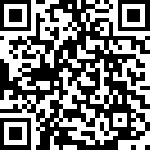
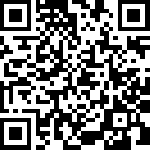
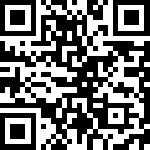

In [29]:
res2

In [30]:
markdowns2 = extractMarkdown(res2, types="all", extract="raw_markdown")
print(f"Number of Markdown Page : {len(markdowns2)}")

Markdown: [Bước tới nội dung](https://vi.wikipedia.org/wiki/H%C3%B4ng#bodyContent)
Trình đơn chính
Trình đơn chính
chuyển sang thanh bên ẩn
Điều hướng 
  * [Trang Chính](https://vi.wikipedia.org/wiki/Trang_Ch%C...
Markdown: [跳至主要內容](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mainContentSkip "跳至主要內容")
[![香港天文台](https://www.hko.gov.hk/images/logo_hko_inside_c.png)](https://www.hko.gov.hk/tc/index.html)
個人版網站![個人版網站](h...
Markdown: [Skip to main content](https://www.weather.gov.hk/en/wxinfo/currwx/fnd.htm#mainContentSkip "Skip to main content")
[![Hong Kong Observatory](https://www.weather.gov.hk/images/logo_hko_inside_e.png)](h...
Markdown: [跳至主要內容](https://www.hko.gov.hk/tc/index.html#ps0 "跳至主要內容")
[![香港天文台](https://www.hko.gov.hk/images/logo_hko_index_c.png)](https://www.hko.gov.hk/tc/index.html)
個人版網站![個人版網站](https://www.hko.gov.hk/im...
Markdown: Menu [ The Weather Company ](https://weather.com/)
  * [ Today 今天](https://weather.com/zh-CN/weather/today/l/3d0654fa7f86f5b20cb9cf9de

In [31]:
Markdown(markdowns2[1][:2000])

[跳至主要內容](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm#mainContentSkip "跳至主要內容")
[![香港天文台](https://www.hko.gov.hk/images/logo_hko_inside_c.png)](https://www.hko.gov.hk/tc/index.html)
個人版網站![個人版網站](https://www.hko.gov.hk/images/PersonalizedIcon.png)分享![分享](https://www.hko.gov.hk/images/icon_share.png)搜尋![搜尋](https://www.hko.gov.hk/images/icon_search.png)語言![語言](https://www.hko.gov.hk/images/icon_language.png)選單![選單](https://www.hko.gov.hk/images/btn_mobileMenu.png)
2025年9月24日 (三)
[![公曆農曆對照](https://www.hko.gov.hk/images/icon_date.png)](https://www.hko.gov.hk/tc/gts/time/conversion.htm "公曆農曆對照")
| 
![三號戒備信號](https://www.hko.gov.hk/images/HKOWarningSymbols_m/warn800_02_tc3.png)
![山泥傾瀉警告](https://www.hko.gov.hk/images/HKOWarningSymbols_m/warn800_14_ls.png)
| 
![雨](https://www.hko.gov.hk/images/HKOWxIconOutline/Outline_wxicon_pic63.png)
27.1°C
90%
(23:30)
  * [ENGEng](javascript:chglang\(0\))
  * [简简](javascript:chglang\(2\))


[文字大小](https://www.hko.gov.hk/tc/other/textsize.html)
[![書籤](https://www.hko.gov.hk/images/icon_bookmark_setting.png)書籤](https://www.hko.gov.hk/tc/bookmark.html)
[![分享](https://www.hko.gov.hk/images/icon_share.png)](javascript:trigger_shareTool\(\))
[這連結會以新視窗打開。![Facebook](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[這連結會以新視窗打開。![X](https://www.hko.gov.hk/images/follow/x_black_100px.png)](https://x.com/intent/tweet?url=https%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[這連結會以新視窗打開。![微博](https://www.hko.gov.hk/images/follow/sina.png)](http://service.weibo.com/share/share.php?url=http%3A%2F%2Fwww.hko.gov.hk%2Ftc%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[![電郵](https://www.hko.gov.hk/images/follow/email.png)](javascript:email\(\))[![二維碼](https://www.hko.gov.hk/images/icon_qrcode.png)](javascript:showQrcode\(\))
  

[![搜索](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/tc/wxinfo/currwx/fnd.htm)
[![搜索](https://www.hko.gov.

## Start Crewai AI Agent Framework

In [32]:
# set LLM model for AI agent
if CFG.USE_OLLAMA:
    llm =LLM(
        model=CFG.ollamallmModel5,
        temperature=0.7,
        max_tokens=CFG.max_tokens,       
    )



### Define AI agent tool

In [36]:
def agent_step_Callback(stepout):
    """
    Callback function for agent step.
    """
    print(f"Agent Step callback: type {type(stepout)} , step: {stepout} ")


def task_callback(taskout):
    """
    Callback function for task.
    """
    logger.info(f"""Task callback:\n
                     ask Agent Name : {taskout.agent}\n
                    task description: {taskout.description}\n
                    task summary: {taskout.summary}\n
                    output: {taskout.raw} """)

In [40]:
if CFG.USE_OPIK:
    # Set
    @track(name="Chat Completion", project_name=opikProjectName)
    async def Complation(msg):
        """Asynchronous chat completion function.
        """
        # global stream
        stream = CFG.stream
        if CFG.USE_OLLAMA:
            model = CFG.ollamallmModel5
            apikey = None
            baseURL = CFG.api_base1
            

        if stream == True:
            streamOption = ChatCompletionStreamOptionsParam(include_usage=True) 
        else:
            streamOption = None

        res = await acompletion(   
            model=model,
            messages=msg,

            stream=stream,
            stream_options=streamOption,

            max_tokens=CFG.max_tokens,
            top_p=CFG.top_p,
            temperature=CFG.temperature,
            presence_penalty=CFG.presence_penalty,
            frequency_penalty=CFG.frequency_penalty,
            api_key=apikey,
            base_url=baseURL

        )
        return res
else:
    # @track(name="Chat Completion", project_name=opikProjectName)
    async def Complation(msg):
        """Asynchronous chat completion function.
        """
        # global stream
        stream = CFG.stream
        if CFG.USE_OLLAMA:
            model = CFG.ollamallmModel5
            apikey = None
            baseURL = CFG.api_base1
            

        if stream == True:
            streamOption = ChatCompletionStreamOptionsParam(include_usage=True) 
        else:
            streamOption = None

        res = await acompletion(   
            model=model,
            messages=msg,

            stream=stream,
            stream_options=streamOption,

            max_tokens=CFG.max_tokens,
            top_p=CFG.top_p,
            temperature=CFG.temperature,
            presence_penalty=CFG.presence_penalty,
            frequency_penalty=CFG.frequency_penalty,
            api_key=apikey,
            base_url=baseURL

        )
        return res



        

In [41]:
# Custom web search tool for AI Agent


In [42]:
# Custom web scraping tool for AI Agent

In [43]:
# Initialize tools
scrape_tool = ScrapeWebsiteTool()
search_tool = SerperDevTool()

In [44]:
# Define Agents
market_researcher = Agent(
    role="Market Researcher",
    goal="Gather and analyze real estate market trends from web and news sources",
    backstory="You are an expert in real estate market analysis with a keen eye for identifying trends, price movements, and emerging opportunities. You use web search and scraping to collect relevant data.",
    # tools=[search_tool, scrape_tool],
    llm=llm,
    verbose=True
)

social_media_analyst = Agent(
    role="Social Media Analyst",
    goal="Analyze social media platforms (LinkedIn, Facebook, Instagram) for real estate discussions and user preferences",
    backstory="You specialize in extracting insights from social media platforms, identifying user sentiments, and detecting real estate preferences from posts and comments.",
    # tools=[search_tool],
    llm=llm,
    verbose=True
)

data_analyst = Agent(
    role="Data Analyst",
    goal="Process and clean data from market and social media sources to identify key patterns",
    backstory="You are a data scientist skilled in cleaning, structuring, and analyzing complex datasets to uncover actionable insights for real estate recommendations.",
    llm=llm,
    verbose=True
)

recommendation_engineer = Agent(
    role="Recommendation Engineer",
    goal="Generate personalized real estate recommendations based on user preferences and market data",
    backstory="You are an AI engineer specializing in recommendation systems, capable of synthesizing market and user data to provide tailored property suggestions.",
    llm=llm,
    verbose=True
)


In [45]:
# Define Tasks
market_research_task = Task(
    description="""Search the web and scrape relevant websites for recent real estate market trends, including price changes, demand patterns, and emerging neighborhoods. Focus on a specific city (e.g., New York). Summarize findings in a concise report.""",
    expected_output="A JSON object containing market trends, including average prices, demand indicators, and notable neighborhoods.",
    agent=market_researcher
)

social_media_task = Task(
    description="""Search LinkedIn and Facebook for posts and discussions related to real estate in the target city (e.g., New York). Identify user preferences, such as desired property types (e.g., apartments, houses), budget ranges, and preferred locations. Summarize insights in a structured format.""",
    expected_output="A JSON object summarizing user preferences from social media, including property types, budget ranges, and preferred locations.",
    agent=social_media_analyst
)

data_analysis_task = Task(
    description="""Combine data from market research and social media analysis. Clean and structure the data, identifying key patterns such as high-demand property types and budget-aligned neighborhoods. Output a structured dataset ready for recommendation.""",
    expected_output="A JSON object with cleaned and analyzed data, highlighting key patterns and correlations.",
    agent=data_analyst
)

recommendation_task = Task(
    description="""Using the analyzed data, generate personalized real estate recommendations for users seeking properties in the target city. Recommendations should include property type, location, and estimated price range, tailored to user preferences and market trends.""",
    expected_output="A JSON object containing a list of recommended properties with details (type, location, price range).",
    agent=recommendation_engineer
)

In [46]:
real_estate_crew = Crew(
    agents=[market_researcher, social_media_analyst, data_analyst, recommendation_engineer],
    tasks=[market_research_task, social_media_task, data_analysis_task, recommendation_task],
    process=Process.sequential,
    verbose=True
)